In [ ]:
import sys 
sys.path.append("../")
import math
from scipy import stats
from scipy.stats import wilcoxon,mannwhitneyu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"]=300
plt.rcParams['font.family'] = 'Times New Roman'
import seaborn as sns
from scipy.stats import pearsonr,spearmanr
from src.utils import create_total_df,create_total_df_sv

from statannotations.Annotator import Annotator
from scikit_posthocs import posthoc_dscf,posthoc_mannwhitney
from tqdm import tqdm
sns.set(font_scale=0.8)

In [5]:
def boxplot_hue(dic_of_df,target:str,dic_of_violin_data:dict,tick_names:list,hue_col='cell',save_name=False):
    figsize = (6,4) 
    xlabel='Group'
    total_target_values=[]
    total_labels=[]
    total_cell_names=[]
    for cell,violin_data_dic in dic_of_violin_data.items():
        
        df = dic_of_df[cell]
        all_data = df[~((df['cos_sim']>0.8)&(df['cos_sim']<1))][target].values

        """
        pairs=[(tick_names[-2],tick_names[-1])]

        pvalues = [
                stats.mannwhitneyu(data_list[-1],all_data)[-1]
                ]
        """
        target_val = np.append(np.concatenate([lis for lis in violin_data_dic[target]]),all_data)
        labels = np.append(
            np.concatenate([np.repeat(f'{label}', len(lis)) for label,lis in zip(tick_names,violin_data_dic[target]) ]),
            np.repeat('All',len(all_data))
            )
        
        total_target_values.extend(target_val)
        total_labels.extend(labels)
        total_cell_names.extend([cell]*len(target_val))
        
    data = {target: total_target_values,
            xlabel: total_labels,
            hue_col: total_cell_names}

    data_df = pd.DataFrame(data)
    # Seabornのboxplotを使用
    plot_params = {
        'data':data_df,
        'x':xlabel,
        'y':target,
        'hue':hue_col,
        'showfliers':False,
    }
    #pairs = [((f"{tick_name}","HEK293T_XRNwt"),(f"{tick_name}","HEK293T_XRNko")) for tick_name in tick_names]
    #pvalues = [stats.mannwhitneyu(data_list[-1],all_data)[-1]]
    sns.boxplot(**plot_params)
    #annotator = Annotator(ax,pairs,**plot_params)
    #annotator.set_pvalues(pvalues)
    #annotator.annotate()
    plt.xlabel(None)
    plt.tight_layout()
    if save_name:
        plt.savefig(f'./results/imgs/{save_name}')

def boxplot_hue_cell(dic_of_df,target:str,dic_of_violin_data:dict,tick_names:list,hue_col='cell',save_name=False):
    figsize = (6,4)
    _, ax = plt.subplots(1, 1, figsize=figsize)
    xlabel='Group'
    total_target_values=[]
    total_labels=[]
    total_cell_names=[]
    for cell,violin_data_dic in dic_of_violin_data.items():
        
        df = dic_of_df[cell]
        all_data = df[~((df['cos_sim']>0.8)&(df['cos_sim']<1))][target].values

        """
        pairs=[(tick_names[-2],tick_names[-1])]

        pvalues = [
                stats.mannwhitneyu(data_list[-1],all_data)[-1]
                ]
        """
        target_val = np.append(np.concatenate([lis for lis in violin_data_dic[target]]),all_data)
        labels = np.append(
            np.concatenate([np.repeat(f'{label}', len(lis)) for label,lis in zip(tick_names,violin_data_dic[target]) ]),
            np.repeat('All',len(all_data))
            )
        
        total_target_values.extend(target_val)
        total_labels.extend(labels)
        total_cell_names.extend([cell]*len(target_val))
        
    data = {target: total_target_values,
            xlabel: total_labels,
            hue_col: total_cell_names}

    data_df = pd.DataFrame(data)
    # Seabornのboxplotを使用
    plot_params = {
        'data':data_df,
        'x':xlabel,
        'y':target,
        'hue':hue_col,
        'showfliers':False,
    }
    pairs = [((tick_name,"HEK293T_XRNwt"),(tick_name,"HEK293T_XRNko")) for tick_name in tick_names]
    pvalues=[]
    for tick_name in tick_names:
        target_df = data_df[data_df[xlabel]==tick_name]
        _,pval = wilcoxon(target_df[target_df[hue_col]=='HEK293T_XRNwt'][target].values,target_df[target_df[hue_col]=='HEK293T_XRNko'][target].values)
        pvalues.append(pval)
    sns.boxplot(**plot_params)
    annotator = Annotator(ax,pairs,**plot_params)
    annotator.set_pvalues(pvalues)
    annotator.annotate()
    plt.xlabel(None)
    plt.tight_layout()
    if save_name:
        plt.savefig(f'./results/imgs/{save_name}')

def boxplot_alltarget(df:pd.DataFrame,all_targets:list,violin_data_dic:dict,tick_names:list,save_name=None,cell_line=None):
    n_rows = math.ceil(len(all_targets) / 3)
    figsize = (10,4*n_rows)
    fig = plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    xlabel=' ' # CosSim bin

    for i,target in enumerate(all_targets):
        ax = fig.add_subplot(n_rows, 3,i+1)
        data_list = violin_data_dic[target]
        all_data = df[~((df['cos_sim']>0.6)&(df['cos_sim']<1))][target].values

        pairs=[(tick_names[-2],tick_names[-1]),
               (tick_names[-3],tick_names[-1])
              ]

        #pvalues = [stats.mannwhitneyu(data_list[-1],all_data)[-1]]
        test_val = np.append(np.concatenate([lis for lis in violin_data_dic[target][-3:]]),all_data)
        test_labels = np.append(
            np.concatenate([np.repeat(f'{label}', len(lis)) for label,lis in zip(tick_names[-3:],violin_data_dic[target][-3:]) ]),
            np.repeat('All',len(all_data))
            )
        test_df = pd.DataFrame({'groups':test_labels,'values':test_val})
        stat_result=posthoc_dscf(test_df, val_col='values', group_col='groups')
        
        pvalues = stat_result.iloc[-1,:].values[:-1]

        target_val = np.append(np.concatenate([lis for lis in violin_data_dic[target]]),df[target].values)
        labels = np.append(
            np.concatenate([np.repeat(f'{label}', len(lis)) for label,lis in zip(tick_names,violin_data_dic[target]) ]),
            np.repeat('All',len(df))
            )
        
        plot_data = {target: target_val,xlabel: labels}

        data_df = pd.DataFrame(plot_data)
        # Seabornのboxplotを使用
        plot_params = {
            'data':data_df,
            'x':xlabel,
            'y':target,
            'showfliers':False,
        }
        sns.boxplot(**plot_params)
        annotator = Annotator(ax,pairs,**plot_params)
        annotator.set_pvalues(pvalues)
        annotator.annotate()
        ax.set(ylabel=None)
        plt.setp(ax.get_xticklabels(), rotation=30)
        plt.title(target)
    if cell_line:
        plt.suptitle(f'{cell_line}')
    plt.tight_layout()
    if save_name:
        plt.savefig(f'./results/imgs/{save_name}')

def boxplot_targets_topbin(df:pd.DataFrame,all_targets:list,violin_data_dic:dict,tick_names:list,save_name=None,values_name='values',tick_name='tick_name',target_name='target'):
    #n_rows = math.ceil(len(all_targets) / 3)
    figsize = (4,2.5)
    _, ax = plt.subplots(1, 1, figsize=figsize)
    sns.set(font_scale=0.8)
    
    plot_data_df={values_name:[],tick_name:[],target_name:[]}
    stats_pairs = []
    pvalues = []

    for i,target in enumerate(all_targets):
        all_df = df[~((df['cos_sim']>0.7)&(df['cos_sim']<1))]
        ## only take highest bin amd all_data
        values =np.concatenate([violin_data_dic[target][-1],all_df[target].values])
        plot_data_df[values_name].extend(values)
        plot_data_df[tick_name].extend(
            np.concatenate([np.repeat(tick_names[-2], len(violin_data_dic[target][-1])),
            np.repeat('All',len(all_df))]))
        plot_data_df[target_name].extend(np.repeat(target,len(values)))

        ## stats info
        stats_pairs.append(((target,tick_names[-2]),
               (target,tick_names[-1])))
        stats_x = violin_data_dic[target][-1]
        stats_y = all_df[target].values
        pvalues.append(stats.mannwhitneyu(stats_x,stats_y)[-1])        
    data_df = pd.DataFrame(plot_data_df)
    # Seabornのboxplotを使用
    plot_params = {
        'data':data_df,
        'x':target_name,
        'y':values_name,
        'hue':tick_name,
        'showfliers':False,
    }
    sns.boxplot(**plot_params)
    
    annotator = Annotator(ax,stats_pairs,**plot_params)
    annotator.set_pvalues(pvalues)
    annotator.annotate()
    
    #ax.set(ylabel=None)
    plt.setp(ax.get_xticklabels(), rotation=15)
    plt.tight_layout()
    plt.xlabel(None)
    #plt.title(target)
   
    if save_name:
        plt.savefig(f'./results/imgs/{save_name}')

def data_binning(df:pd.DataFrame,target_labels:list):
    thresh = np.arange(0,0.8,0.1)
    thresh = np.append(thresh,1.0)
    bin_dic = dict()
    tick_names=[]
    violin_data_dic={label:[] for label in target_labels}
    for i in range(len(thresh)-1):
        upper_th = thresh[i+1]
        lower_th = thresh[i]
        tmp_df = df[(df['cos_sim']>lower_th)&(df['cos_sim']<upper_th)]
        for l in target_labels:
            violin_data_dic[l].append(tmp_df[l].values)
        tmp_dic = tmp_df.describe().loc['mean',target_labels]
        tmp_dic['count'] = tmp_df.describe().loc['count'].values[0]
        bin_dic[f"{lower_th:.1f}-{upper_th:.1f}"] = tmp_dic
        tick_names.append(f"{lower_th:.1f}-{upper_th:.1f}")
    tick_names.append('All')
    bin_dic['All'] = dict(df.describe().loc['mean',target_labels],count=len(df))
    bin_df = pd.DataFrame(bin_dic).T
    return (violin_data_dic,tick_names,bin_df)

def data_binning_targetENST(df:pd.DataFrame,target_labels:list,target_enst_id:list,target_name:str):
    tick_names=[]
    violin_data_dic={label:[] for label in target_labels}
    
    upper_th = 0.8
    lower_th = 0.7
    tmp_df = df[(df['cos_sim']>lower_th)&(df['cos_sim']<upper_th)]
    target_df = df[df['ENST_ID'].isin(target_enst_id)]
    for l in target_labels:
        violin_data_dic[l].append(tmp_df[l].values)
        violin_data_dic[l].append(target_df[l].values)
    
    tick_names.append(f"{lower_th:.1f}-{upper_th:.1f}")
    tick_names.append(f"{target_name}")
    tick_names.append('All')

    return (violin_data_dic,tick_names)

def concat_df(tot_df:pd.DataFrame,ribo:pd.DataFrame,rna:pd.DataFrame):
    remover=lambda x:x.split('.')[0]
    ribo['ENST_ID']=ribo['transcript_id'].apply(remover)
    rna['ENST_ID']=rna['transcript_id'].apply(remover)
    df_concat=pd.merge(tot_df,ribo,on='ENST_ID',how='inner')
    df_concat=pd.merge(df_concat,rna,on='ENST_ID',how='inner')
    df_concat=df_concat[(df_concat['cds_len']!=0)&(df_concat['TPM_rna']!=0)]
    df_concat['TE'] = df_concat['TPM_ribo']/df_concat['TPM_rna']

    return df_concat

#seq_df = pd.read_csv('/home/ksuga/whole_mrna_predictor/UTR_PairPred/data/human/gencode44_utr_gene_unique_cdhit09.csv')
seq_df = pd.read_csv('../data/human/gencode44_utr_gene_unique_cdhit09.csv')
remover= lambda x:x.split(".")[0]

#cl_dir = "/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/runs/contrastive_learning_10fold_shuffle_seed0"
cl_dir = "/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/runs/contrastive_learning_10fold_rinalmo_whole_ave_seed1"
tot_df_cl = create_total_df(cl_dir,seq_df)
tot_df_cl=tot_df_cl.drop("ENST_ID",axis=1).rename(columns={"ENST_ID_PRE":"ENST_ID"})


In [6]:
cl = "/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/runs/contrastive_learning_10fold_shuffle_seed0"
cl_rinalmo = "/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/runs/contrastive_learning_10fold_rinalmo_whole_ave_seed1"

cl_df = create_total_df(cl,seq_df).drop("ENST_ID",axis=1).rename(columns={"ENST_ID_PRE":"ENST_ID"})
cl_rinalmo_df = create_total_df(cl_rinalmo,seq_df).drop("ENST_ID",axis=1).rename(columns={"ENST_ID_PRE":"ENST_ID"})

In [ ]:
## Plot cos sim hist
plt.hist(cl_df['cos_sim'],alpha=0.5,bins=20,label='RNA-FM')
plt.hist(cl_rinalmo_df['cos_sim'],alpha=0.5,bins=20,label='Rinalmo')
plt.xlabel('Cos Sim')
plt.ylabel('Sample num')
plt.legend()
plt.tight_layout()
plt.savefig('./results/imgs/cos_sim_dist_of_embedder')

# 1. TE cell line

In [6]:
## All cell line comprehensive process
#cell_lines = np.unique(seq_info['cell_line'])
seq_info = pd.read_table('/home/ksuga/whole_mrna_predictor/UTR_PairPred/Biocontainer-pipeline/input/sample_info.txt')

cell_lines=['Brain', 'Breast', 'ES', 'Eye', 'HEK293',
            'Hela', 'HepG2','PC3', 'fibloblast']
target_labels=['TPM_rna','TPM_ribo','TE']
cell_df_dict={}

for cell in cell_lines:
    print(cell)
    ribo_srr = seq_info[(seq_info['cell_line']==cell)&(seq_info['seq_type']=='ribo-seq')].srr_id.values[0]
    rna_srr =  seq_info[(seq_info['cell_line']==cell)&(seq_info['seq_type']=='rna-seq')].srr_id.values[0]

    ribo = pd.read_csv(f'./Biocontainer-pipeline/output/{ribo_srr}/ReadCount_cds.csv',index_col=0).rename(columns={'TPM_cds':'TPM_ribo'})
    rna = pd.read_csv(f'./Biocontainer-pipeline/output/{rna_srr}/ReadCount_cds.csv',index_col=0).iloc[:,[0,-1]].rename(columns={'TPM_cds':'TPM_rna'})
    cell_df = concat_df(tot_df_cl,ribo,rna)
    cell_df_dict[cell]=cell_df

    #violin_data_dic,tick_names,_ = data_binning(cell_df,target_labels)
    ###violin_data_dic,tick_names,_ = data_binning_perc(cell_df,target_labels,sort_col='cos_sim')
    #boxplot_alltarget(df=cell_df,all_targets=['TPM_rna','TPM_ribo','TE'],violin_data_dic=violin_data_dic,tick_names=tick_names,save_name=None,cell_line=cell)

Brain
Breast
ES
Eye
HEK293
Hela
HepG2
PC3
fibloblast


In [ ]:
cell_lines=['HEK293T_XRNko','HEK293T_XRNwt']
same_gene=list(set(cell_df_dict['HEK293T_XRNko']['GENE'].values)&set(cell_df_dict['HEK293T_XRNwt']['GENE'].values))
target_cell_df = {}
bin_data_dic = {}
for cell in cell_lines:
    target_cell_df[cell]=cell_df_dict[cell].set_index('GENE').loc[same_gene]
    bin_data,tick_names,_ = data_binning(target_cell_df[cell],target_labels)
    bin_data_dic[cell]=bin_data

boxplot_hue_cell(dic_of_df=target_cell_df,target='TPM_ribo',dic_of_violin_data=bin_data_dic,tick_names=tick_names)


## 1.2  GO analysis

In [32]:
import pickle
with open("./data/human/go_enst_table.pkl","rb") as f:
    go_enst_table,enst_go_table = pickle.load(f)

target_go_id = ["GO:0016071"]
target_enst_id = []
for go_id in target_go_id:
    target_enst_id.extend(go_enst_table[go_id])
print(len(target_enst_id))

31


In [ ]:
## All cell line comprehensive process
#cell_lines = np.unique(seq_info['cell_line'])
seq_info = pd.read_table('/home/ksuga/whole_mrna_predictor/UTR_PairPred/Biocontainer-pipeline/input/sample_info.txt')
cell_lines =['ES','Eye', 'Hela', 'PC3', 'fibloblast','Brain','HepG2','HEK293']
target_labels=['TPM_rna','TPM_ribo','TE']
target='TE'
dic_of_df={}
dic_of_violin_data={}

for cell in cell_lines:
    ribo_srr = seq_info[(seq_info['cell_line']==cell)&(seq_info['seq_type']=='ribo-seq')].srr_id.values[0]
    rna_srr =  seq_info[(seq_info['cell_line']==cell)&(seq_info['seq_type']=='rna-seq')].srr_id.values[0]

    ribo = pd.read_csv(f'./Biocontainer-pipeline/output/{ribo_srr}/ReadCount_cds.csv',index_col=0).rename(columns={'TPM_cds':'TPM_ribo'})
    rna = pd.read_csv(f'./Biocontainer-pipeline/output/{rna_srr}/ReadCount_cds.csv',index_col=0).iloc[:,[0,-1]].rename(columns={'TPM_cds':'TPM_rna'})
    cell_df = concat_df(tot_df_cl,ribo,rna)
    
    violin_data_dic,tick_names= data_binning_targetENST(cell_df,target_labels,target_enst_id,target_name='GO:0009410')
    #boxplot_alltarget(df=cell_df,all_targets=['TPM_rna','TPM_ribo','TE'],violin_data_dic=violin_data_dic,tick_names=tick_names,save_name=None,cell_line=cell)
    dic_of_df[cell]=cell_df
    dic_of_violin_data[cell]=violin_data_dic

boxplot_hue(dic_of_df,target,dic_of_violin_data,tick_names,save_name=f'boxplot_GO0016071_comparison_seed1')

# 2. Cell line comparison

### 2.1 Comparison HighCosSim stats in each cell

In [9]:
#cell_lines = np.unique(seq_info['cell_line'])
seq_info = pd.read_table('/home/ksuga/whole_mrna_predictor/UTR_PairPred/Biocontainer-pipeline/input/sample_info.txt')
cell_lines =['ES','Eye', 'Hela', 'PC3', 'fibloblast','Breast','Brain','HEK293','HepG2']
target_labels=['TPM_rna','TPM_ribo','TE']
cell_df_dict={}
for cell in cell_lines:
    ribo_srr = seq_info[(seq_info['cell_line']==cell)&(seq_info['seq_type']=='ribo-seq')].srr_id.values[0]
    rna_srr =  seq_info[(seq_info['cell_line']==cell)&(seq_info['seq_type']=='rna-seq')].srr_id.values[0]

    ribo = pd.read_csv(f'../Biocontainer-pipeline/output/{ribo_srr}/ReadCount_cds.csv',index_col=0).rename(columns={'TPM_cds':'TPM_ribo'})
    rna = pd.read_csv(f'../Biocontainer-pipeline/output/{rna_srr}/ReadCount_cds.csv',index_col=0).iloc[:,[0,-1]].rename(columns={'TPM_cds':'TPM_rna'})
    cell_df = concat_df(tot_df_cl,ribo,rna)
    cell_df_dict[cell]=cell_df

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HEK293 vs. HepG2: Custom statistical test, P_val:9.000e-01
Brain vs. HepG2: Custom statistical test, P_val:5.309e-01
Breast vs. HepG2: Custom statistical test, P_val:9.000e-01
fibloblast vs. HepG2: Custom statistical test, P_val:9.000e-01
PC3 vs. HepG2: Custom statistical test, P_val:9.000e-01
Hela vs. HepG2: Custom statistical test, P_val:9.000e-01
Eye vs. HepG2: Custom statistical test, P_val:7.681e-01
ES vs. HepG2: Custom statistical test, P_val:9.000e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HEK293 vs. HepG2: Custom statistical test, P_val:8.154e-01
Brain vs. HepG2: Custom statistical test, P_val:9.000e-01
Breast vs. HepG2: Custom statistical

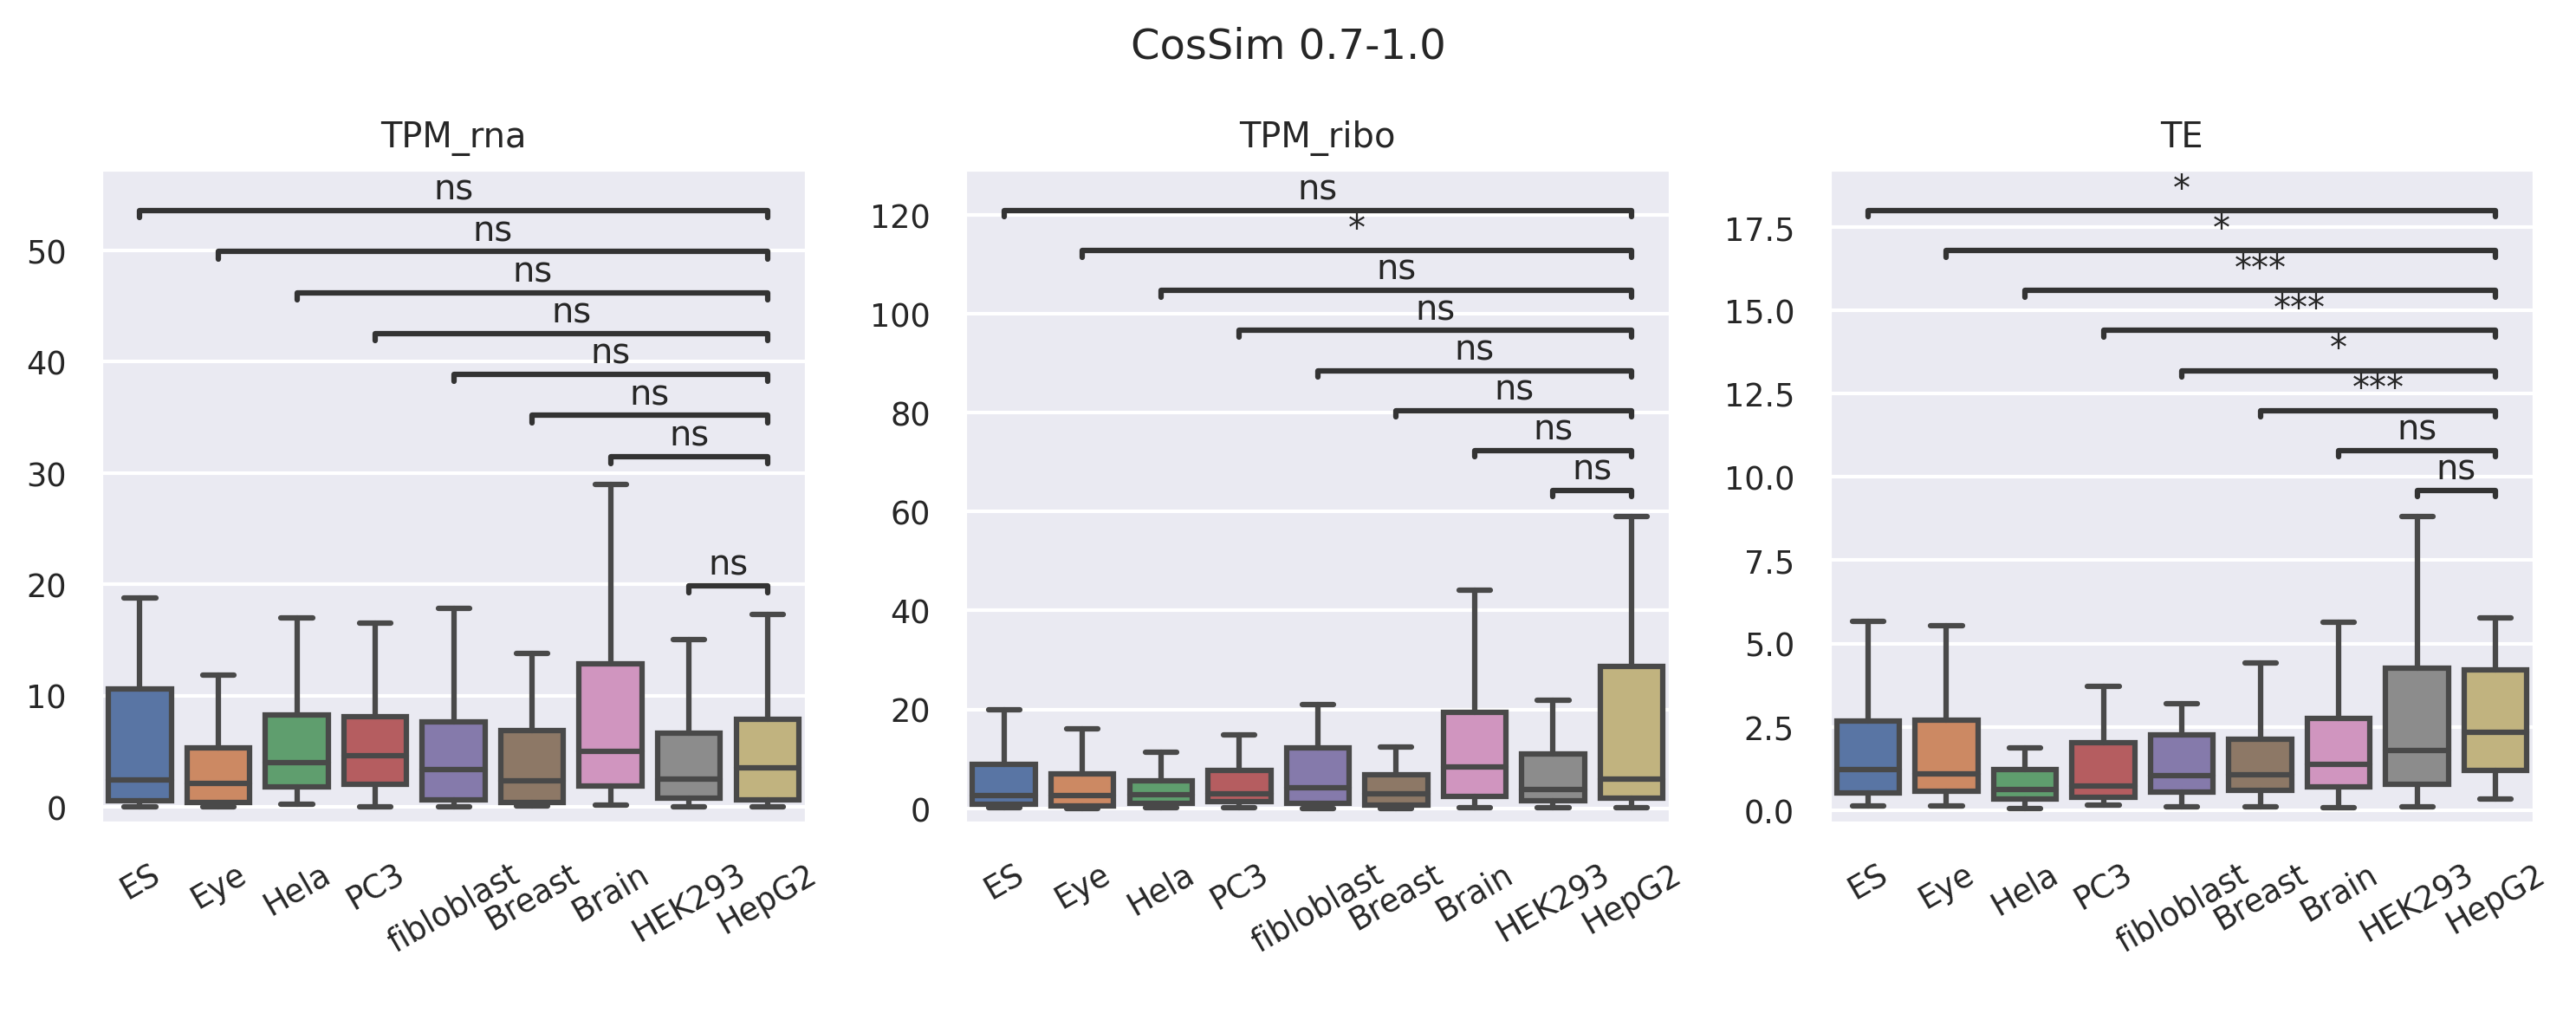

In [10]:
low_thresh=0.7
high_thresh=1.0
target_list=['TPM_rna','TPM_ribo','TE']
high_data_dic_plot={label:[] for label in target_labels}
labels = []

## Create cell df dict
for cell,df in cell_df_dict.items():
    tmp_df = df[(df['cos_sim']>low_thresh)&(df['cos_sim']<=high_thresh)]
    labels.extend([cell]*len(tmp_df))
    for l in target_labels:
        high_data_dic_plot[l].extend(tmp_df[l].values)

## Plot
figsize = (10,4)
fig = plt.figure(figsize=figsize)
sns.set(font_scale=0.8)
xlabel=' ' # CosSim bin
for i,target in enumerate(target_list):

    ax = fig.add_subplot(1, len(target_list),i+1)
    
    xlabel=' '
    data = {target: high_data_dic_plot[target],
            xlabel: labels}

    data_df = pd.DataFrame(data)
    # Seabornのboxplotを使用
    plot_params = {
        'data':data_df,
        'x':xlabel,
        'y':target,
        'showfliers':False,
    }
    
    test_data = pd.DataFrame({'groups':labels,'values':high_data_dic_plot[target]})
    stat_result=posthoc_dscf(test_data, val_col='values', group_col='groups')

    pairs=[(stat_result.columns.values[i],stat_result.columns.values[-1]) for i in range(0,len(stat_result)-1,1)]
    pvalues=stat_result.iloc[-1].values[:-1]
    sns.boxplot(**plot_params)
    annotator = Annotator(ax,pairs,**plot_params)
    annotator.set_pvalues(pvalues)
    annotator.annotate()
    plt.xticks(rotation=30)
    plt.title(f"{target}")
    ax.set(ylabel=None)

    plt.tight_layout()
plt.suptitle(f'CosSim {low_thresh:.1f}-{high_thresh:.1f}')
plt.tight_layout()
#plt.savefig(f'./results/imgs/boxplot_each_cell_stats_{low_thresh}-{high_thresh}_rinalmo.png')

### 2.1.2 top bin comparison

In [27]:
def boxplot_targets_topbin_cell(cell_df_dict:dict,save_name=None,values_name='values',tick_name='tick_name',target_name='cell',target_label=['TE']):
    # n_rows = math.ceil(len(all_targets) / 3)
    figsize = (6,4)
    _, ax = plt.subplots(1, 1, figsize=figsize)
    sns.set(font_scale=0.8)

    plot_data_df={values_name:[],tick_name:[],target_name:[]}
    stats_pairs = []
    pvalues = []
    for cell,cell_df in cell_df_dict.items():
        plot_cell_df={values_name:[],tick_name:[],target_name:[]}
        for target in target_label:
            all_df = cell_df[~((cell_df['cos_sim']>0.7)&(cell_df['cos_sim']<1))]
            violin_data_dic,tick_names,_=data_binning(cell_df,target_label)
            ## only take highest bin amd all_data
            values =np.concatenate([violin_data_dic[target][-1],all_df[target].values])
            plot_data_df[values_name].extend(values)
            plot_data_df[tick_name].extend(
                np.concatenate([np.repeat(tick_names[-2], len(violin_data_dic[target][-1])),
                np.repeat('All',len(all_df))]))
            plot_data_df[target_name].extend(np.repeat(cell,len(values)))

            plot_cell_df[values_name].extend(values)
            plot_cell_df[tick_name].extend(
                np.concatenate([np.repeat(tick_names[-2], len(violin_data_dic[target][-1])),
                np.repeat('All',len(all_df))]))
            """
            plot_cell_df[target_name].extend(np.repeat(cell,len(values)))

            plot_cell_df = pd.DataFrame(plot_cell_df)

            stat_result=posthoc_dscf(plot_cell_df, val_col=values_name, group_col=tick_name)
            pvalues.append(stat_result.iloc[0,1])
            """
            ## stats info
            stats_pairs.append(((cell,tick_names[-2]),
                (cell,tick_names[-1])))
            stats_x = violin_data_dic[target][-1]
            stats_y = all_df[target].values

            pvalues.append(stats.mannwhitneyu(stats_x,stats_y)[-1])        
    data_df = pd.DataFrame(plot_data_df)
    # Seabornのboxplotを使用
    plot_params = {
        'data':data_df,
        'x':target_name,
        'y':values_name,
        'hue':tick_name,
        'showfliers':False,
    }
    sns.boxplot(**plot_params)

    annotator = Annotator(ax,stats_pairs,**plot_params)
    annotator.set_pvalues(pvalues)
    annotator.annotate()

    # ax.set(ylabel=None)
    plt.setp(ax.get_xticklabels(), rotation=15)
    plt.xlabel(None)
    plt.tight_layout()
    # plt.title(target)

    if save_name:
        plt.savefig(f'../results/imgs/{save_name}')

In [15]:
cell_df_dict.keys()

dict_keys(['ES', 'Eye', 'Hela', 'PC3', 'fibloblast', 'Breast', 'Brain', 'HEK293', 'HepG2'])

In [18]:
diff_cells = ['Hela','PC3','Breast','HEK293','HepG2']
diff_cell_dict = {cell:cell_df_dict[cell] for cell in diff_cells}

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PC3_0.7-1.0 vs. PC3_All: Custom statistical test, P_val:3.210e-04
Hela_0.7-1.0 vs. Hela_All: Custom statistical test, P_val:3.387e-04
Breast_0.7-1.0 vs. Breast_All: Custom statistical test, P_val:2.086e-07
HEK293_0.7-1.0 vs. HEK293_All: Custom statistical test, P_val:4.978e-03
HepG2_0.7-1.0 vs. HepG2_All: Custom statistical test, P_val:3.566e-06


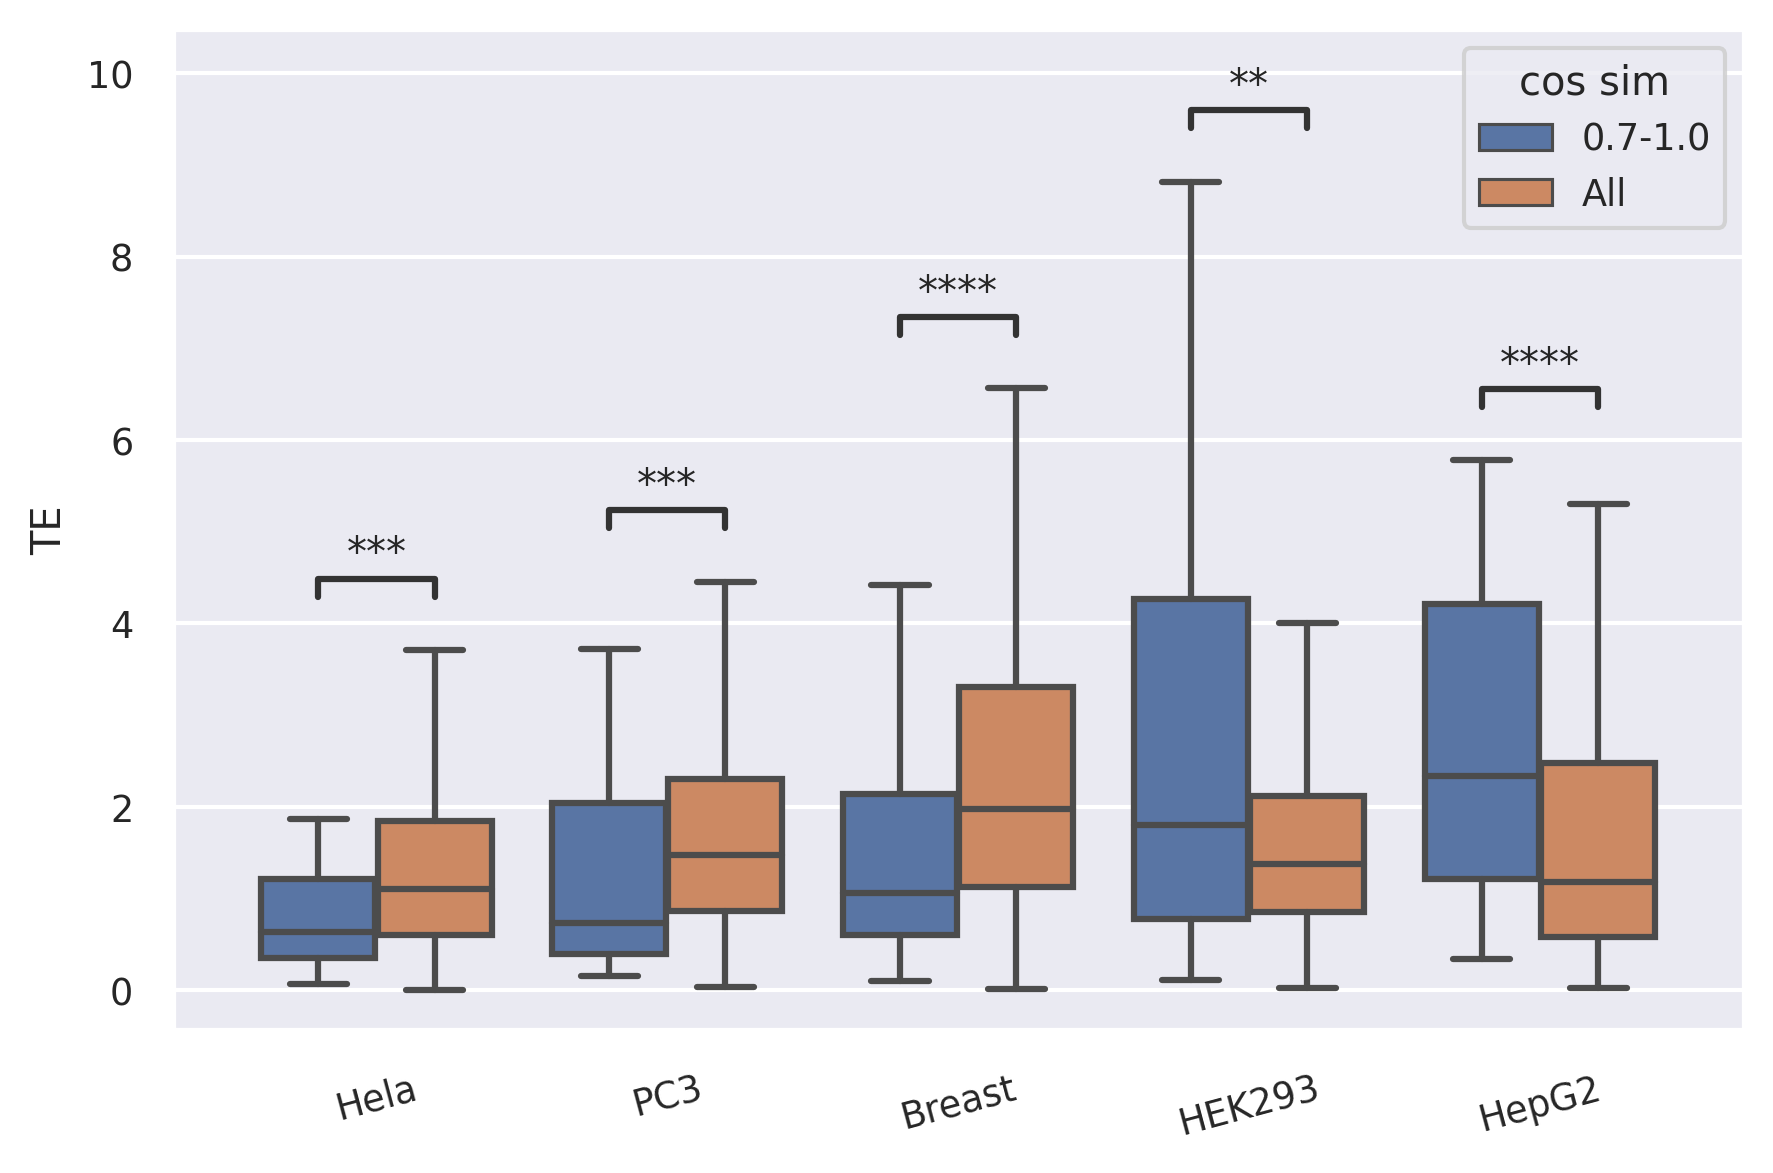

In [28]:
# boxplot_targets_topbin_cell(cell_df_dict,values_name='TE',tick_name='cos sim',save_name='boxplot_cell_topbin')
boxplot_targets_topbin_cell(diff_cell_dict,values_name='TE',tick_name='cos sim',save_name='boxplot_cell_topbin_diff')

## 2.3 Calcurate Corr for all gene

In [ ]:
seq_info = pd.read_table('/home/ksuga/whole_mrna_predictor/UTR_PairPred/Biocontainer-pipeline/input/sample_info.txt')
#cell_lines = np.unique(seq_info['cell_line'])
cell_lines = ['Brain','HEK293','HepG2','Hela','Lymphoblastoid', 'PC3', 'fibloblast', 'ES','Breast','Eye']
thresh=np.arange(0,0.8,0.1)
thresh = np.append(thresh,1.0)

target_labels=['TPM_rna','TPM_ribo','TE']
cell_target='TE'

cell_df_dict={}
cell_median_dict={}
dic_for_all_target_label={}
## Create cell df dic.
for cell in cell_lines:
    ribo_srr = seq_info[(seq_info['cell_line']==cell)&(seq_info['seq_type']=='ribo-seq')].srr_id.values[0]
    rna_srr =  seq_info[(seq_info['cell_line']==cell)&(seq_info['seq_type']=='rna-seq')].srr_id.values[0]

    ribo = pd.read_csv(f'./Biocontainer-pipeline/output/{ribo_srr}/ReadCount_cds.csv',index_col=0).rename(columns={'TPM_cds':'TPM_ribo'})
    rna = pd.read_csv(f'./Biocontainer-pipeline/output/{rna_srr}/ReadCount_cds.csv',index_col=0).iloc[:,[0,-1]].rename(columns={'TPM_cds':'TPM_rna'})
    cell_df = concat_df(tot_df_cl,ribo,rna)
    cell_df_dict[cell]=cell_df
    median_dic={'All':np.median(cell_df[cell_target].values)}
    for i in range(len(thresh)-1):
        low_thresh=thresh[i]
        high_thresh=thresh[i+1]
        tmp_df = cell_df[(cell_df['cos_sim']>low_thresh)&(cell_df['cos_sim']<=high_thresh)]
    
        median_dic[f'{low_thresh:.1f}-{high_thresh:.1f}']=np.median(tmp_df[cell_target].values) 
    cell_median_dict[cell]=median_dic
cell_median_df = pd.DataFrame(cell_median_dict).T


for target_label in target_labels:
    gene_all_corr_dict={}
    for gene in tqdm(tot_df_cl['GENE']):
        all_gene_flg=True
        gene_dict={}
        for cell,cell_df in cell_df_dict.items():
            tmp_df = cell_df[cell_df['GENE']==gene]
            if len(tmp_df)==0:
                all_gene_flg=False
                continue
            gene_dict[cell]=tmp_df.loc[:,target_labels].values[0]
        if all_gene_flg==False:
            continue
        gene_df = pd.DataFrame(gene_dict).T
        gene_df.columns = target_labels
        ## calc corr section
        gene_corr_dict={}
        for col in cell_median_df.columns.values:
            x = cell_median_df[col].values
            y = gene_df[target_label].values
            corr,_ = pearsonr(x,y)
            gene_corr_dict[col]=corr
        gene_all_corr_dict[gene]=gene_corr_dict


    gene_corr_df = pd.DataFrame(gene_all_corr_dict).T
    dic_for_all_target_label[target_label]=gene_corr_df

for target,df in dic_for_all_target_label.items():
    df['diff']=abs(df['0.7-1.0'])-abs(df['All'])
    df = df.sort_values('diff',ascending=False)
    df.to_csv(f'/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/analysis/gene_median_corr_cellTE_{target}_rinalmo.csv')

In [9]:
gene='HBA1'
gene_dict={}
for cell,cell_df in cell_df_dict.items():
    tmp_df = cell_df[cell_df['GENE']==gene]
    if len(tmp_df)==0:
        all_gene_flg=False
        continue
    gene_dict[cell]=tmp_df.loc[:,target_labels].values[0]
print(len(gene_dict))

3


### 2.3.2 Check corr for each target gene

In [4]:
seq_info = pd.read_table('/home/ksuga/whole_mrna_predictor/UTR_PairPred/Biocontainer-pipeline/input/sample_info.txt')
cell_df_dict={}
for cell in cell_lines:
    ribo_srr = seq_info[(seq_info['cell_line']==cell)&(seq_info['seq_type']=='ribo-seq')].srr_id.values[0]
    rna_srr =  seq_info[(seq_info['cell_line']==cell)&(seq_info['seq_type']=='rna-seq')].srr_id.values[0]

    ribo = pd.read_csv(f'./Biocontainer-pipeline/output/{ribo_srr}/ReadCount_cds.csv',index_col=0).rename(columns={'TPM_cds':'TPM_ribo'})
    rna = pd.read_csv(f'./Biocontainer-pipeline/output/{rna_srr}/ReadCount_cds.csv',index_col=0).iloc[:,[0,-1]].rename(columns={'TPM_cds':'TPM_rna'})
    cell_df = concat_df(tot_df_cl,ribo,rna)
    cell_df_dict[cell]=cell_df

In [10]:
cell_lines = ['Brain','HEK293','HepG2','Hela', 'PC3', 'fibloblast', 'ES','Breast','Eye']
#low_thresh=0.7
#high_thresh=0.8
target_labels=['TPM_rna','TPM_ribo','TE']
cell_target='TE'
gene='HBA1'
high_data_median={cell:[] for cell in cell_lines}

fig = plt.figure(figsize=(9,6))
total_fig_count=0
for thresh_pair in [(0.0,1.0),(0.7,1.0)]:
    low_thresh=thresh_pair[0]
    high_thresh=thresh_pair[1]
    high_data_median={cell:[] for cell in cell_lines}
    gene_dict={}
    for cell,cell_df in cell_df_dict.items():
        gene_dict[cell]=cell_df[cell_df['GENE']==gene].loc[:,target_labels].values[0]
        tmp_df = cell_df[(cell_df['cos_sim']>low_thresh)&(cell_df['cos_sim']<=high_thresh)]
        
        for l in target_labels:
            high_data_median[cell].append(np.median(tmp_df[l].values))
    print(high_data_median)
    median_df = pd.DataFrame(high_data_median).T
    median_df.columns = target_labels

    gene_df = pd.DataFrame(gene_dict).T
    gene_df.columns = target_labels

    # Plot 
    prot_df_dict = {gene:gene_df}
    gene_target=['TPM_rna','TPM_ribo','TE']
    for i,target in enumerate(gene_target):
        ax = fig.add_subplot(2,len(gene_target),total_fig_count+1)
        total_fig_count+=1
        x = median_df[cell_target]
        y = gene_df[target]
        pearson,_=pearsonr(x,y)
        plt.scatter(x,y,label=f'pearson={pearson:.3f}')
        for cell_name,x_axis,y_axis in zip(median_df.index.values,x,y):
            plt.annotate(cell_name,(x_axis,y_axis),fontsize=6)
        plt.legend(fontsize=6)
        if total_fig_count>=4:
            plt.xlabel(f'High CosSim({cell_target})')
        plt.ylabel(f'{gene}({target})')
        #plt.title(f'{low_thresh:.1f}-{high_thresh:.1f}')
        plt.title(f'{target}({low_thresh:.1f}-{high_thresh:.1f})')
        plt.tight_layout()
#plt.savefig(f'./results/imgs/CosSim_corr_riboribo_rinalmo_{gene}.png')

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 2700x1800 with 0 Axes>

## 2.4 Re-analysis

In [23]:
import pandas as pd
corr_df_dic={}
target_labels=['TPM_rna','TPM_ribo','TE']
for target in target_labels:
    corr_df_dic[target]=pd.read_csv(f'/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/analysis/gene_median_corr_cellribo_{target}_rinalmo.csv')

In [24]:
top=4000
top=int(len(corr_df_dic['TPM_ribo'])*0.05)
sort_col='0.7-0.8'
rna=corr_df_dic['TPM_rna'].sort_values(sort_col,ascending=True).rename(columns={'Unnamed: 0':'GENE'})
ribo=corr_df_dic['TPM_ribo'].sort_values(sort_col,ascending=False).rename(columns={'Unnamed: 0':'GENE'})
te = corr_df_dic['TE'].sort_values(sort_col,ascending=True).rename(columns={'Unnamed: 0':'GENE'})
#merge = pd.merge(ribo,rna,on='Unnamed: 0',how='inner')
#merge = pd.merge(merge,te,on='Unnamed: 0',how='inner')

In [7]:
ribo['Unnamed: 0'].to_csv('./results/analysis/gene_median_corr_cellTE_ribo_postop5%_rinalmo.csv',index=False)

## 3. MFE corr

In [14]:
mfe_df = pd.read_csv('/home/ksuga/whole_mrna_predictor/UTR_PairPred/data/human/gencode44_utr_gene_unique_cdhit09_mfe.csv',index_col=0)
remover= lambda x:x.split(".")[0]

#cl_dir = "/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/runs/contrastive_learning_10fold_shuffle_seed0"
cl_dir = "/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/runs/contrastive_learning_10fold_rinalmo_whole_ave_seed1"
mfe_df_cl = create_total_df(cl_dir,mfe_df)
mfe_df_cl=mfe_df_cl.drop("ENST_ID",axis=1).rename(columns={"ENST_ID_PRE":"ENST_ID"})

In [ ]:
target_labels=['5UTR_head_mfe', '5UTR_tail_mfe', '5UTR_tail_cds_mfe','3UTR_head_cds_mfe', '3UTR_head_mfe', '3UTR_tail_mfe']
violin_data_dic,tick_names,bin_df = data_binning(mfe_df_cl,target_labels)
boxplot_alltarget(df=mfe_df_cl,all_targets=target_labels,violin_data_dic=violin_data_dic,tick_names=tick_names,save_name='boxplot_MFE_rinalmo.png')

## 3.2 Length

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.7-1.0 vs. All: Custom statistical test, P_val:1.000e-03
0.6-0.7 vs. All: Custom statistical test, P_val:1.000e-03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.7-1.0 vs. All: Custom statistical test, P_val:1.000e-03
0.6-0.7 vs. All: Custom statistical test, P_val:1.000e-03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.7-1.0 vs. All: Custom statistical test, P_val:5.205e-03
0.6-0.7 vs. All: Custom statistical test, P_val:2.168e-01


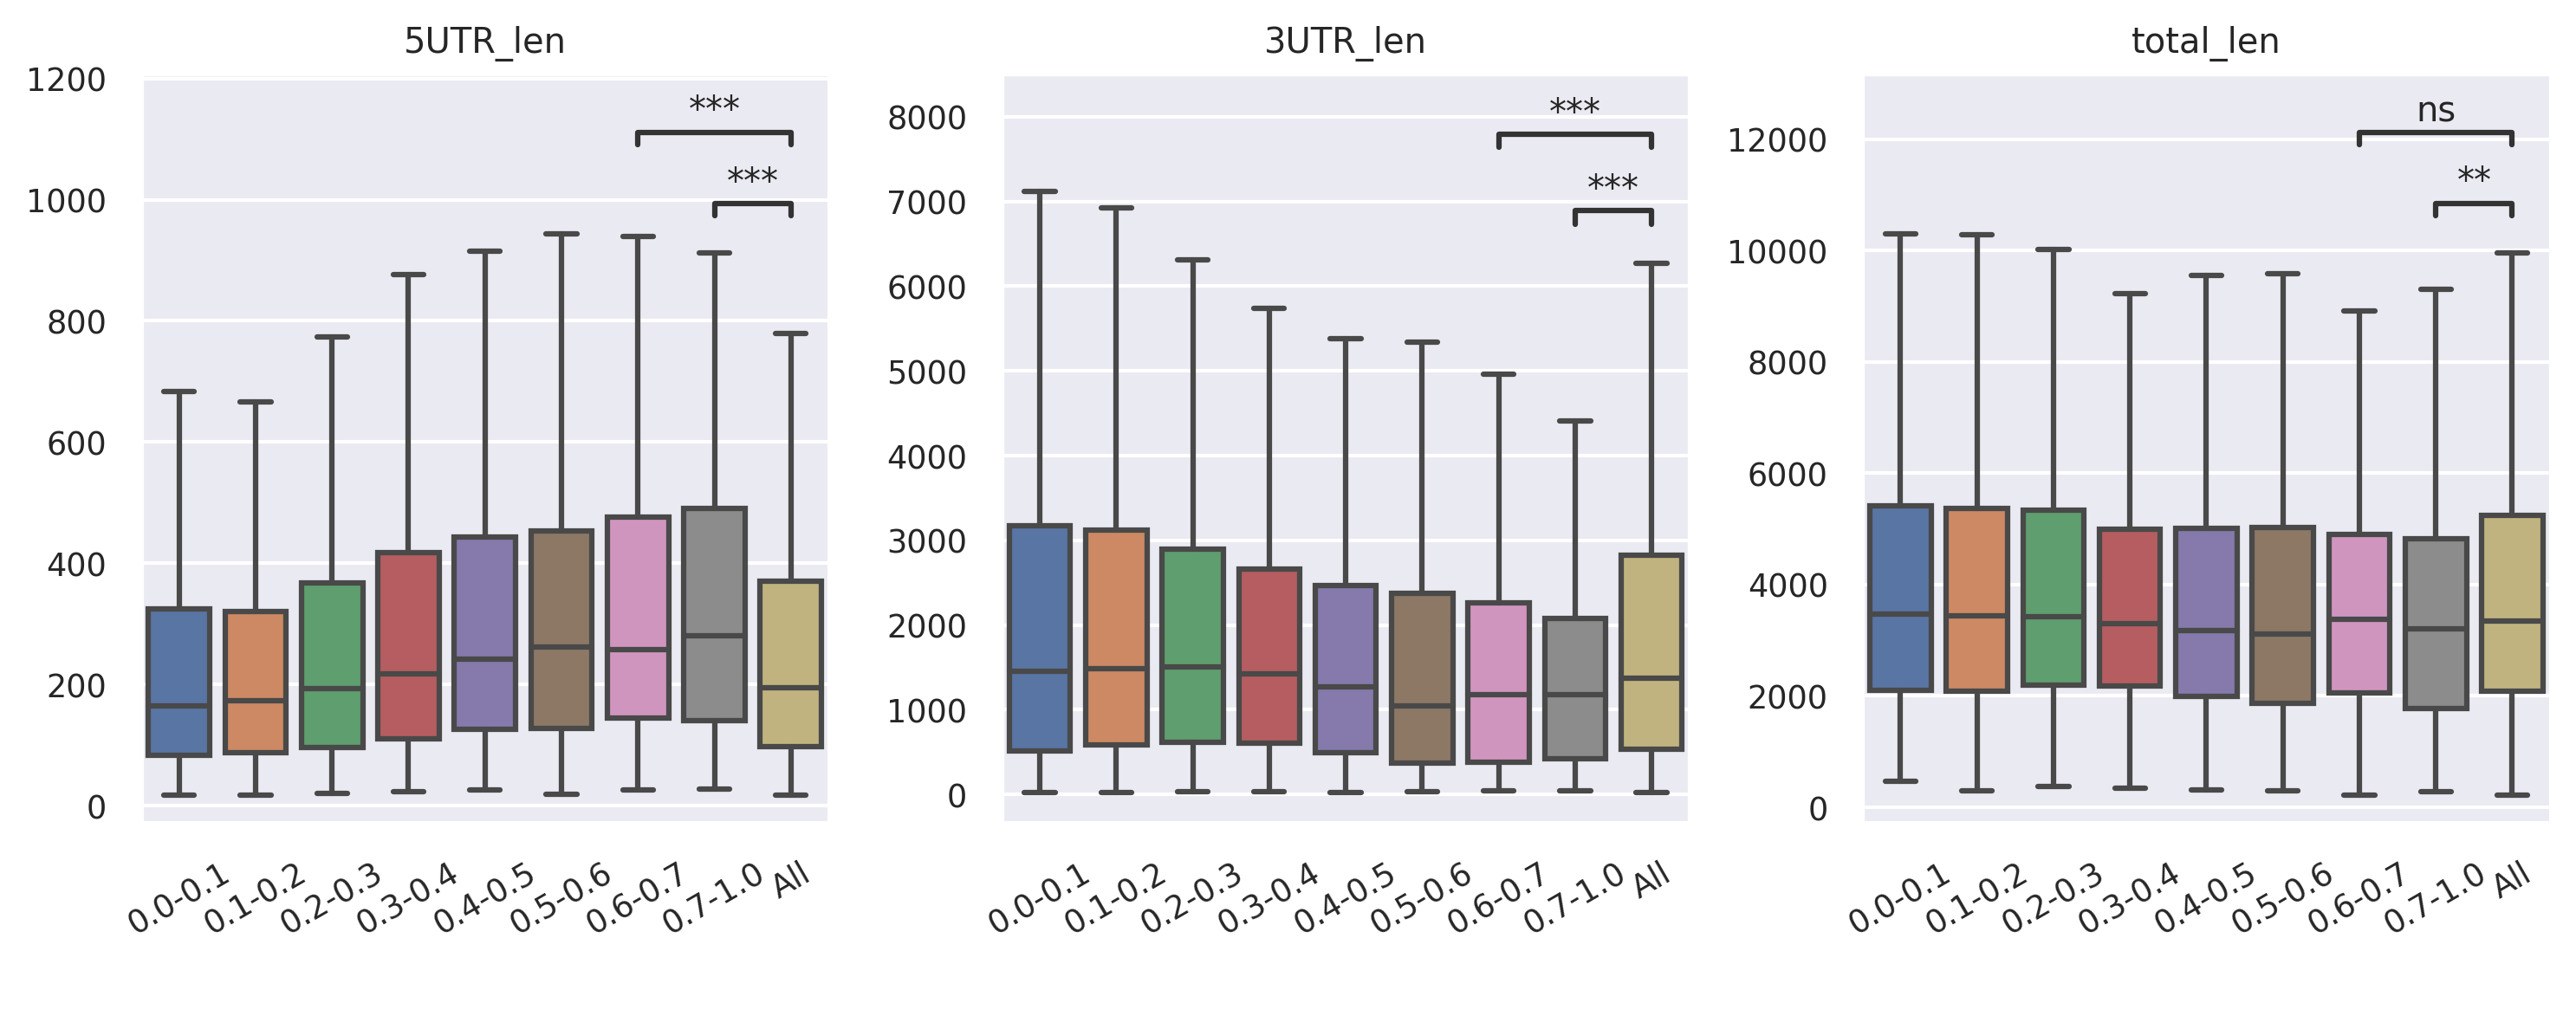

In [ ]:
targets = ['5UTR_len','3UTR_len','CDS_len','total_len']
violin_data_dic,tick_names,bin_df = data_binning(tot_df_cl,target_labels=targets)
boxplot_alltarget(tot_df_cl,all_targets=targets,violin_data_dic=violin_data_dic,tick_names=tick_names,save_name='boxplot_each_length_rinalmo.png')


In [5]:
tot_df_cl

,utr5,utr3,label,pred,correct,logits,cos_sim,ENST_ID,GENE,CDS,3UTR,total_len,5UTR_len,CDS_len,3UTR_len,align_forward,align_rev_cmp
293,9257,9257,1,True,True,0.705522,0.873735,ENST00000528841,BRSK2,AUGACAUCGACGGGGAAGGACGGCGGCGCGCAGCACGCGCAGUAUG...,ACACACUAGCCCCCCCCCCCAGCACAGCACUGACAGCGGCUGCCUC...,4528,351,2211,1966,28.205128,18.233618
296,3716,3716,1,True,True,0.696336,0.829912,ENST00000618052,H3C7,AUGGCACGCACGAAGCAAACAGCUCGUAAGUCCACUGGCGGCAAAG...,GUUGUACUGAGGGUGUGCGCCAACUUAAACCAAAGGCUCUUUUCAG...,494,30,411,53,30.000000,13.333333
299,3520,3520,1,True,True,0.695916,0.827926,ENST00000328345,POU3F2,AUGGCGACCGCAGCGUCUAACCACUACAGCCUGCUCACCUCCAGCG...,ACUCGAGCUGGGGGAGGGGCAGAGCGCGGGGCUCCCCCUCCCCUUC...,4885,300,1332,3253,26.333333,5.333333
405,1384,1384,1,True,True,0.694372,0.820638,ENST00000293441,SHANK1,AUGACCCACAGCCCCGCGACAAGCGAGGACGAGGAACGCCACAGUG...,UGGCUGGCCUGGACGGACCAGCCCCGUCCACAGAACUCUUGAGCCU...,9636,440,6486,2710,40.454545,14.772727
28,7625,7625,1,True,True,0.694133,0.819514,ENST00000394166,NR2F2,AUGGCAAUGGUAGUCAGCACGUGGCGCGACCCCCAGGACGAGGUGC...,AUAAAUAAAAUAAGAAGGGGGAGUGAAACAGAGAAAGAAAAGGCAA...,5287,1406,1245,2636,2.773826,2.987198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,3689,3689,1,False,False,0.396502,-0.420062,ENST00000567435,UBL7,AUGUCUCUCUCAGACUGGCACCUGGCGGUGAAGCUGGCUGACCAGC...,ACUCCCUGCUUCCCCUGAACCCCCAGCAAGUUGCAGAGGCUACUGC...,1720,464,1143,113,9.698276,2.801724
784,6853,6853,1,False,False,0.395291,-0.425126,ENST00000306324,HOXD4,AUGGUCAUGAGUUCGUAUAUGGUGAACUCCAAGUAUGUGGACCCCA...,AAGUGGGGACCCUGGGCCCAUCUCUCCCUGCGCACCAGGCUGAGCC...,1136,84,768,284,13.095238,7.142857
1622,7255,7255,1,False,False,0.394273,-0.429387,ENST00000337014,HEXD,AUGUCAGGUUCCACUCCAUUUCAGAUGAGAUUAGUUCAUUUAGACC...,UCUGCAUGUGUGACACUGAUUCUUUGGAAAUAAAGAGUGGAAGCUG...,2285,474,1758,53,1.476793,1.898734
458,9617,9617,1,False,False,0.392457,-0.436998,ENST00000334134,FGF3,AUGGGCCUAAUCUGGCUGCUACUGCUCAGCCUGCUGGAGCCCGGCU...,CUGGGCCUGGUGGCCACCGCCAGAGCUCCUGGCGACAUCUUGGCGU...,1540,483,720,337,9.523810,5.590062


In [10]:
tot_df_cl[tot_df_cl['GENE']=='GAPDH']

,utr5,utr3,label,pred,correct,logits,cos_sim,ENST_ID,GENE,CDS,3UTR,total_len,5UTR_len,CDS_len,3UTR_len,align_forward,align_rev_cmp
549,7799,7799,1,False,False,0.480993,-0.076063,ENST00000396861,GAPDH,AUGGGGAAGGUGAAGGUCGGAGUCAACGGAUUUGGUCGUAUUGGGC...,GACCCCUGGACCACCAGCCCCAGCAAGAGCACAAGAGGAAGAGAGA...,1348,151,1008,189,13.245033,11.258278


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.7-1.0 vs. All: Custom statistical test, P_val:2.053e-01
0.6-0.7 vs. All: Custom statistical test, P_val:4.478e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.7-1.0 vs. All: Custom statistical test, P_val:1.000e-03
0.6-0.7 vs. All: Custom statistical test, P_val:4.068e-01


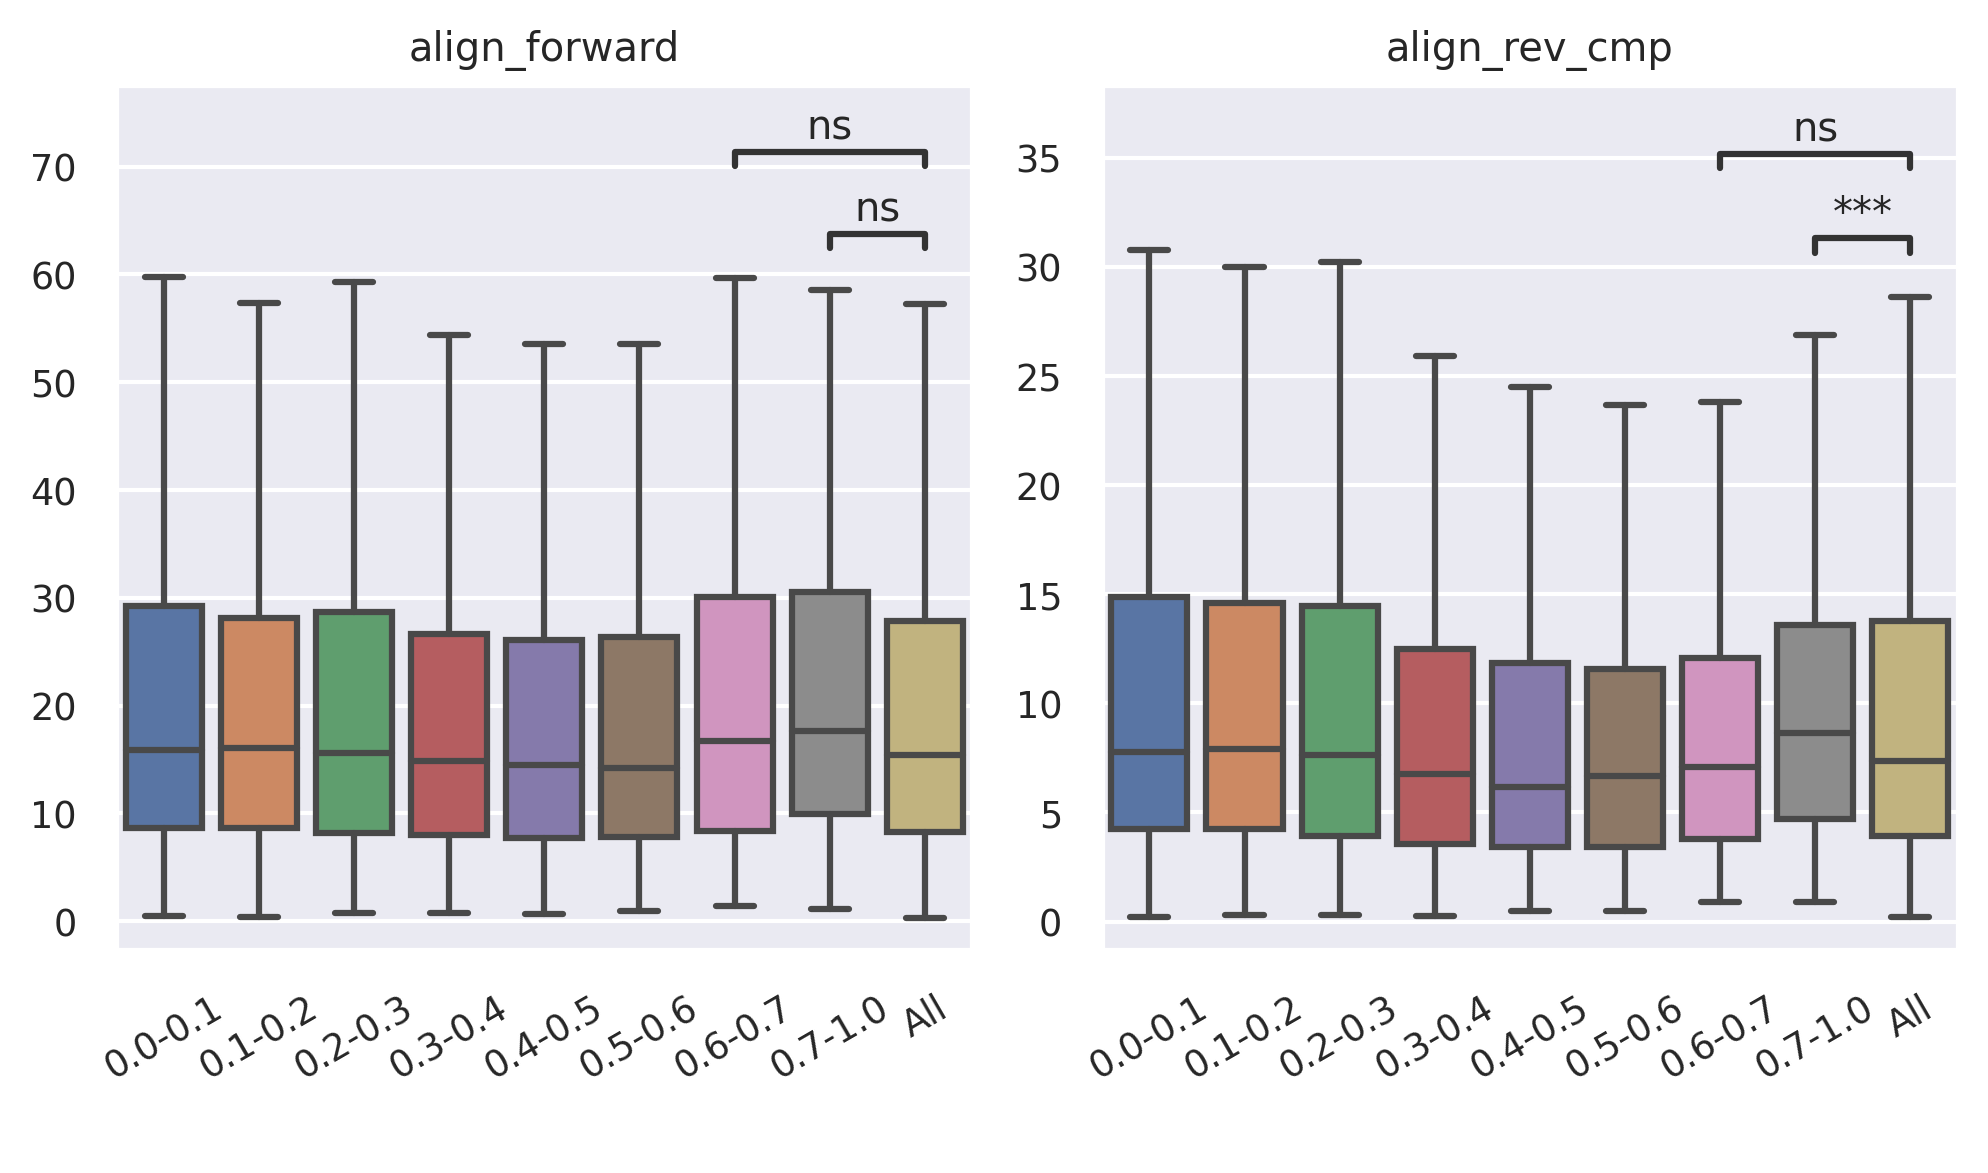

In [7]:
targets = ['align_forward','align_rev_cmp']
violin_data_dic,tick_names,bin_df = data_binning(tot_df_cl,target_labels=targets)
boxplot_alltarget(tot_df_cl,all_targets=targets,violin_data_dic=violin_data_dic,tick_names=tick_names,save_name='boxplot_alignment_scores.png')

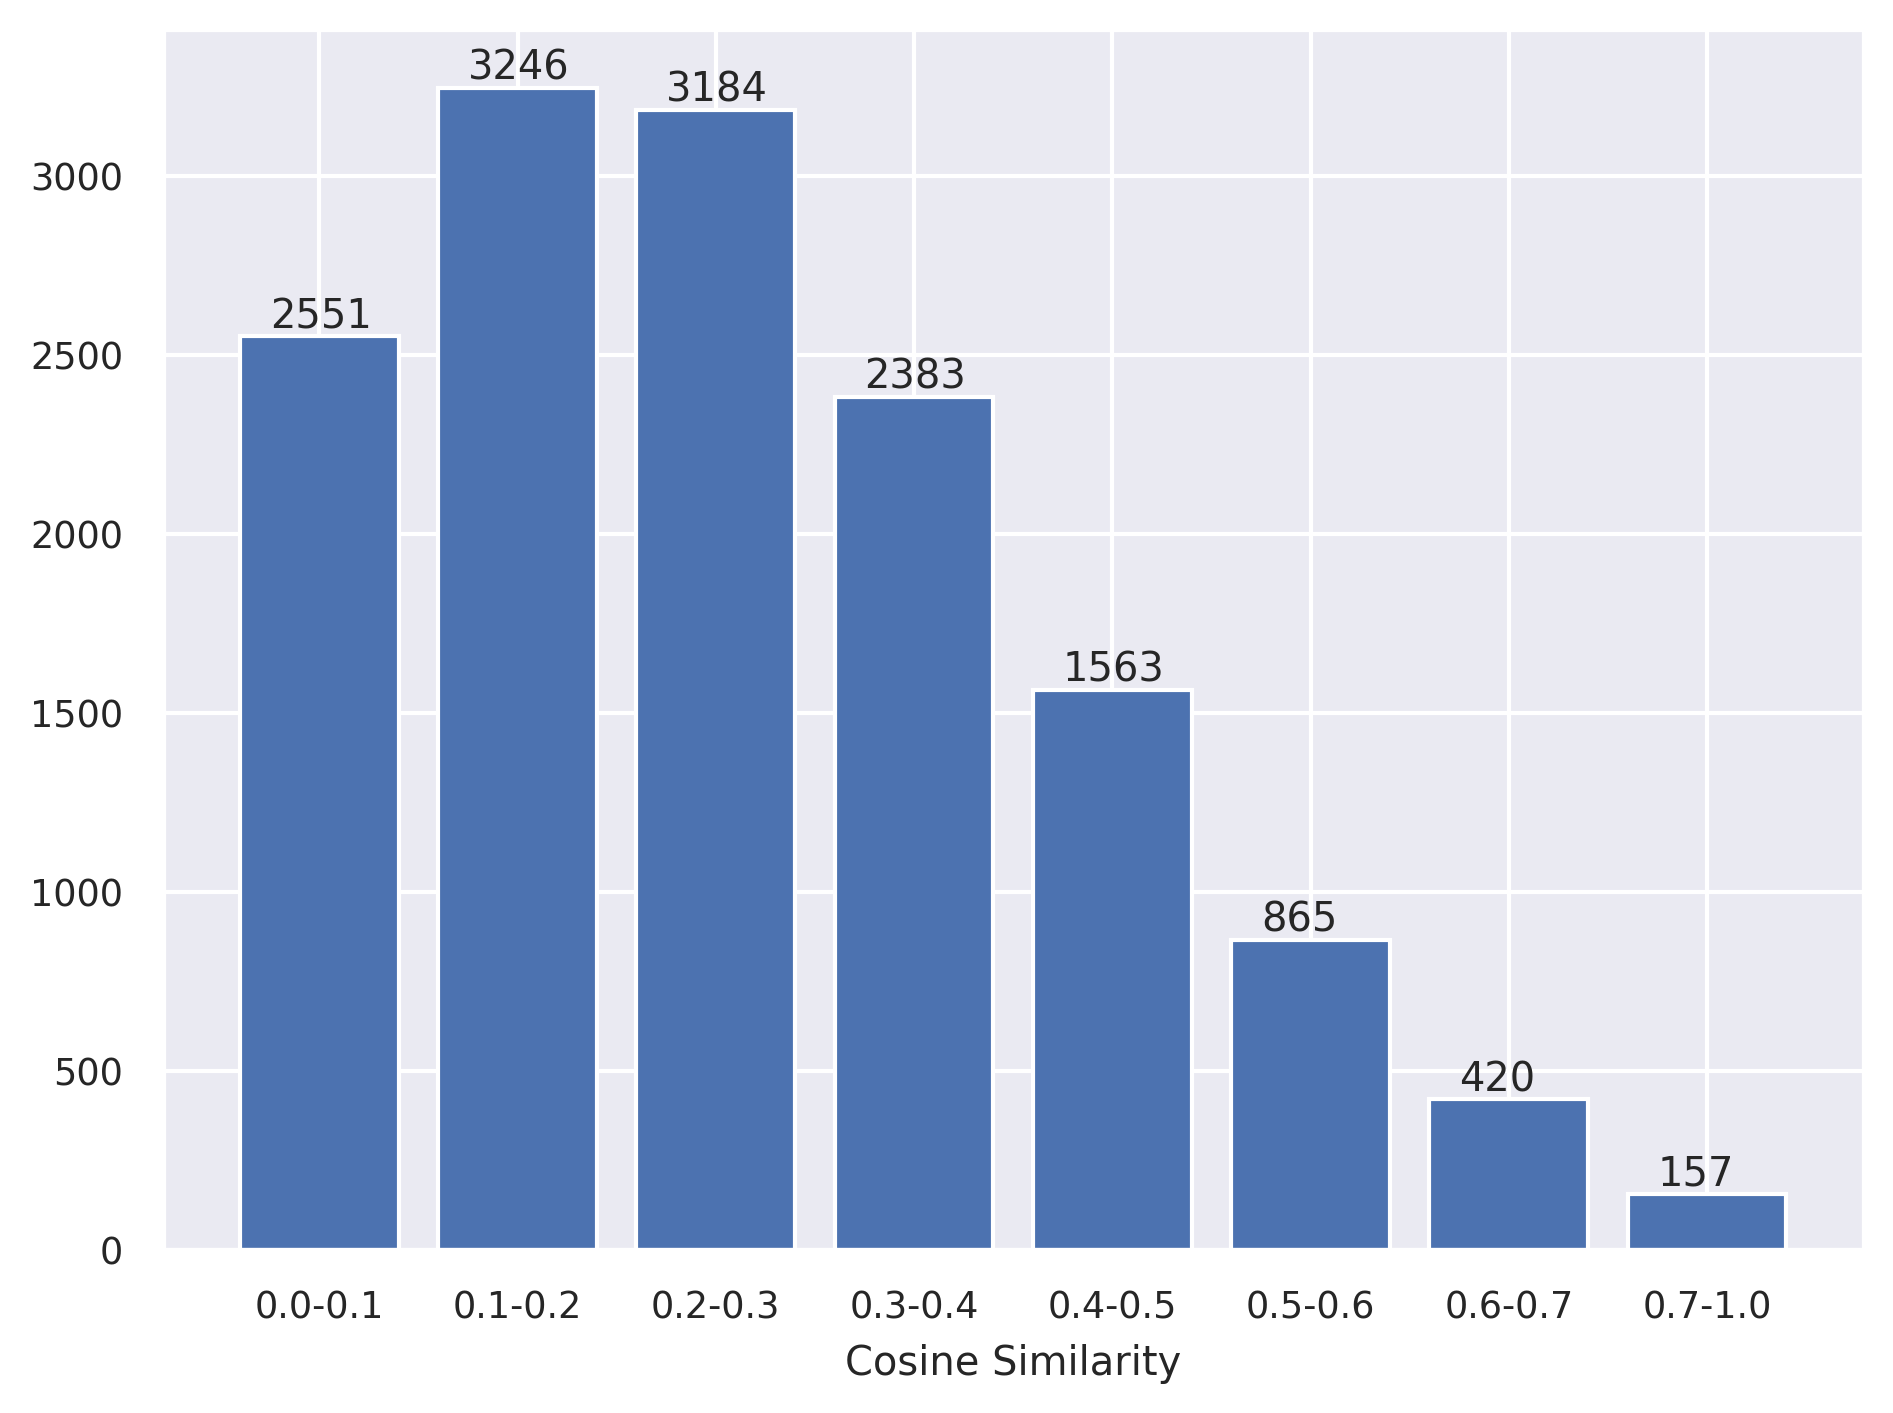

In [23]:
plt.bar(x=tick_names[:-1],height=bin_df['count'][:-1])
plt.xlabel('Cosine Similarity')
for i,count in enumerate(bin_df['count'][:-1]):
    plt.text(i-0.25,count+25,f'{int(count)}')
plt.tight_layout()
plt.savefig('./results/imgs/cosine_similarity_sample_dist_rinalmo.png')


## 4. XRN1 analysis

In [7]:
te_df = pd.read_table('/home/ksuga/whole_mrna_predictor/UTR_PairPred/Biocontainer-pipeline/output/GSE132725_TE_XRN1.txt')
counts=pd.read_table('/home/ksuga/whole_mrna_predictor/UTR_PairPred/Biocontainer-pipeline/output/GSE132725_Final_table_readcounts_RNAseq_vs_Riboseq.txt')

In [8]:
te_df

,geneIDs,disper,pval,padj,TEcontrol,TEXrn1KO,log2FC_TE(Xrn1KO vs control),Unnamed: 7
0,A1BG,0.004704,0.100458,0.306512,0.062690,0.098893,0.657627,NaN
1,AAAS,0.005377,0.335221,0.603009,0.119293,0.105375,-0.178979,NaN
2,AACS,0.002695,0.000158,0.002663,0.081226,0.048933,-0.731129,NaN
3,AADAT,0.008476,0.002143,0.020916,0.038821,0.017354,-1.161613,NaN
4,AAED1,0.008574,0.364893,0.629205,0.071099,0.083684,0.235123,NaN
...,...,...,...,...,...,...,...,...
10100,ZYG11A,0.004224,0.000005,0.000137,0.224790,0.124500,-0.852439,NaN
10101,ZYG11B,0.003357,0.016647,0.095160,0.079702,0.100484,0.334290,NaN
10102,ZYX,0.001485,0.260176,0.522425,0.056543,0.050619,-0.159662,NaN
10103,ZZEF1,0.001684,0.000000,0.000000,0.075861,0.029785,-1.348749,NaN


In [9]:
def calc_TPM(df:pd.DataFrame):
    for col in counts.columns[2:]:
        total_count = df[col].sum()
        len_per_1000bp = df[col]/df['width'] * 10**3
        read_per_100M = len_per_1000bp/total_count * 10**6 
        df[f'{col}_TPM'] = read_per_100M

    return df
te_df.rename(columns={'geneIDs':'GENE'},inplace=True)

"""
tpm_counts = calc_TPM(counts)
tpm_counts['TEcontrol']=tpm_counts['WT_1_Ribo_TPM']/tpm_counts['WT_1_RNA_TPM']
tpm_counts['TEXRNko'] = tpm_counts['Xrn1_1_Ribo_TPM']/tpm_counts['Xrn1_1_RNA_TPM']
tpm_counts['log2FC'] = np.log2(tpm_counts['TEXRNko']/tpm_counts['TEcontrol'])
tpm_counts.rename(columns={'gene':'GENE'},inplace=True)
"""
merge = pd.merge(tot_df_cl,te_df,on='GENE',how='inner')
merge

,utr5,utr3,label,pred,correct,logits,cos_sim,ENST_ID,GENE,3UTR,...,5UTR_len,CDS_len,3UTR_len,disper,pval,padj,TEcontrol,TEXrn1KO,log2FC_TE(Xrn1KO vs control),Unnamed: 7
0,9257,9257,1,True,True,0.705522,0.873735,ENST00000528841,BRSK2,ACACACUAGCCCCCCCCCCCAGCACAGCACUGACAGCGGCUGCCUC...,...,351,2211,1966,0.002819,0.036553,0.162503,0.030432,0.020673,-0.557791,NaN
1,3520,3520,1,True,True,0.695916,0.827926,ENST00000328345,POU3F2,ACUCGAGCUGGGGGAGGGGCAGAGCGCGGGGCUCCCCCUCCCCUUC...,...,300,1332,3253,0.003399,0.513658,0.749696,0.043947,0.039942,-0.137856,NaN
2,7625,7625,1,True,True,0.694133,0.819514,ENST00000394166,NR2F2,AUAAAUAAAAUAAGAAGGGGGAGUGAAACAGAGAAAGAAAAGGCAA...,...,1406,1245,2636,0.002136,0.024219,0.122531,0.048865,0.060180,0.300485,NaN
3,443,443,1,True,True,0.693368,0.815915,ENST00000429448,TTYH3,CUGUUCCCUCAGAGCGACAGUACACCUCCAGCAUGAGAGCCAAAUA...,...,195,1581,3155,0.003716,0.027793,0.135840,0.016159,0.011627,-0.474946,NaN
4,11154,11154,1,True,True,0.692237,0.810597,ENST00000379608,TFAP2A,GGCUCUCCUCCCGCCCCGCCCCUCCCACGCCUCACCAGCCCCCCGC...,...,795,1296,1740,0.003714,0.531715,0.763200,0.061573,0.055848,-0.140792,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8303,13657,13657,1,False,False,0.398724,-0.410783,ENST00000530797,RPLP2,AUUCCUGCUCCCCUGCAAAUAAAGCCUUUUUACACAUC,...,251,348,38,0.008381,0.719100,0.873665,0.124568,0.130335,0.065286,NaN
8304,14491,14491,1,False,False,0.398124,-0.413289,ENST00000314616,SUPT6H,GGGGCCUGCUCCUCGGACUCUGGUUACCUCUGAGGCUGGGAAAGGC...,...,169,5181,1054,0.023137,0.035688,0.160207,0.057695,0.036881,-0.645576,NaN
8305,586,586,1,False,False,0.397489,-0.415940,ENST00000649205,NAA60,UGUCGGCUGGGCAGCCGCCACCAGGCCCCACCCUUCGGCCGCCCGC...,...,359,729,2054,0.002193,0.187379,0.435517,0.027533,0.022422,-0.296291,NaN
8306,3689,3689,1,False,False,0.396502,-0.420062,ENST00000567435,UBL7,ACUCCCUGCUUCCCCUGAACCCCCAGCAAGUUGCAGAGGCUACUGC...,...,464,1143,113,0.001785,0.156084,0.396528,0.091642,0.101815,0.151862,NaN


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.7-1.0 vs. All: Custom statistical test, P_val:8.401e-01
0.6-0.7 vs. All: Custom statistical test, P_val:3.632e-01


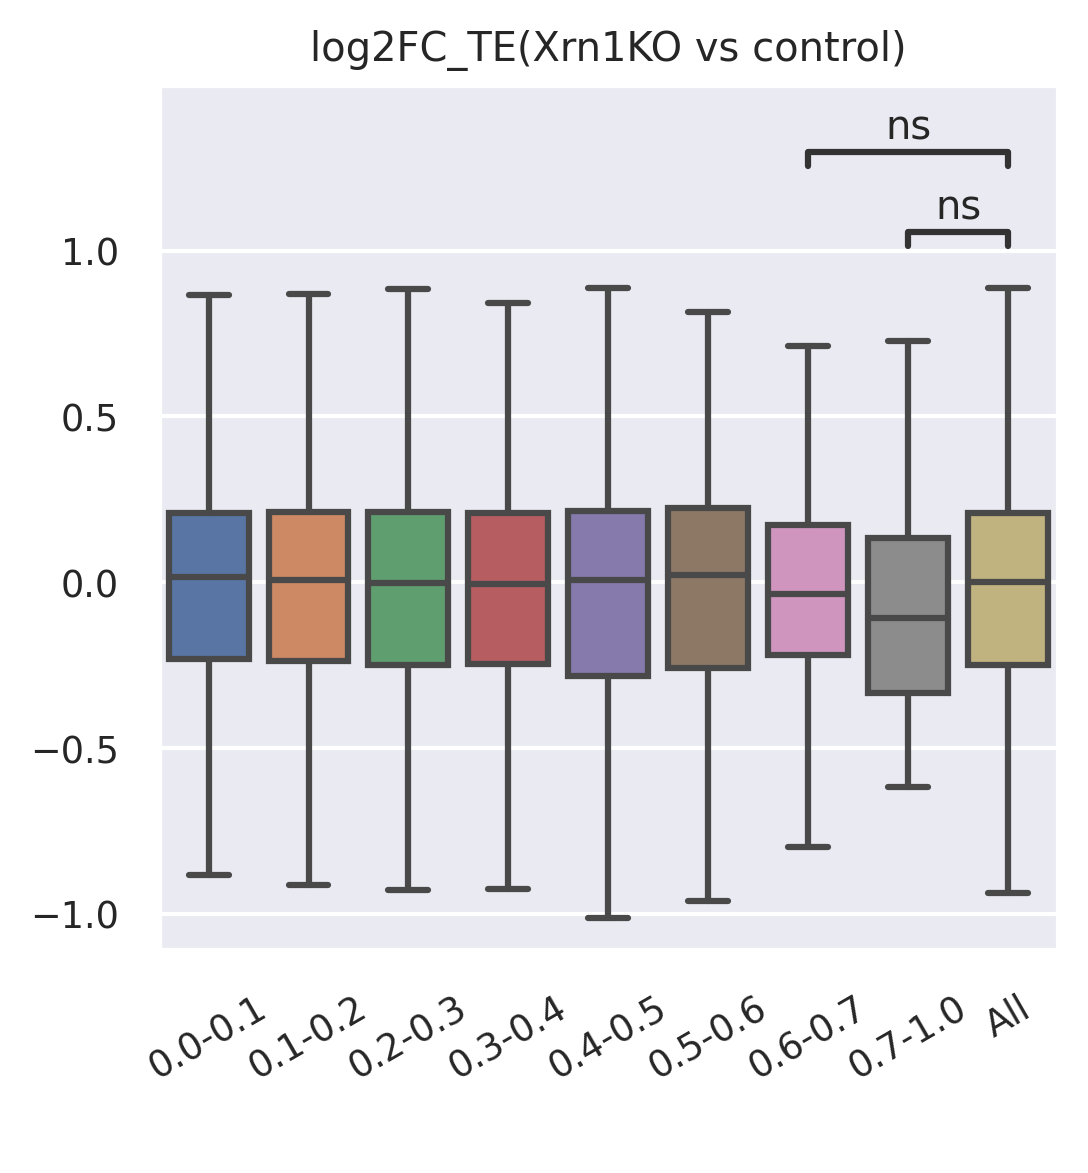

In [15]:
target_labels=['log2FC_TE(Xrn1KO vs control)']
violin_data_dic,tick_names,bin_df = data_binning(merge,target_labels)
boxplot_alltarget(merge,all_targets=target_labels,violin_data_dic=violin_data_dic,tick_names=tick_names)

In [23]:
def boxplot_hue(df,violin_data_dic:dict,tick_names:list,save_name=False):
    figsize = (6,4)
    xlabel='Group'
    total_target_values=[]
    total_labels=[]
    total_cell_names=[]
    for target,violin_data in violin_data_dic.items():
        
        all_data = df[~((df['cos_sim']>0.7)&(df['cos_sim']<1))][target].values

        target_val = np.append(np.concatenate([lis for lis in violin_data]),all_data)
        labels = np.append(
            np.concatenate([np.repeat(f'{label}', len(lis)) for label,lis in zip(tick_names,violin_data) ]),
            np.repeat('All',len(all_data))
            )
        
        total_target_values.extend(target_val)
        total_labels.extend(labels)
        total_cell_names.extend([target]*len(target_val))
        
    data = {'TE': total_target_values,
            xlabel: total_labels,
            'cell': total_cell_names}

    data_df = pd.DataFrame(data)
    # Seabornのboxplotを使用
    plot_params = {
        'data':data_df,
        'x':xlabel,
        'y':'TE',
        'hue':'cell',
        'showfliers':False,
    }
    sns.boxplot(**plot_params)
    #annotator = Annotator(ax,pairs,**plot_params)
    #annotator.set_pvalues(pvalues)
    #annotator.annotate()
    plt.xlabel(None)
    plt.tight_layout()
    if save_name:
        plt.savefig(f'./results/imgs/{save_name}')

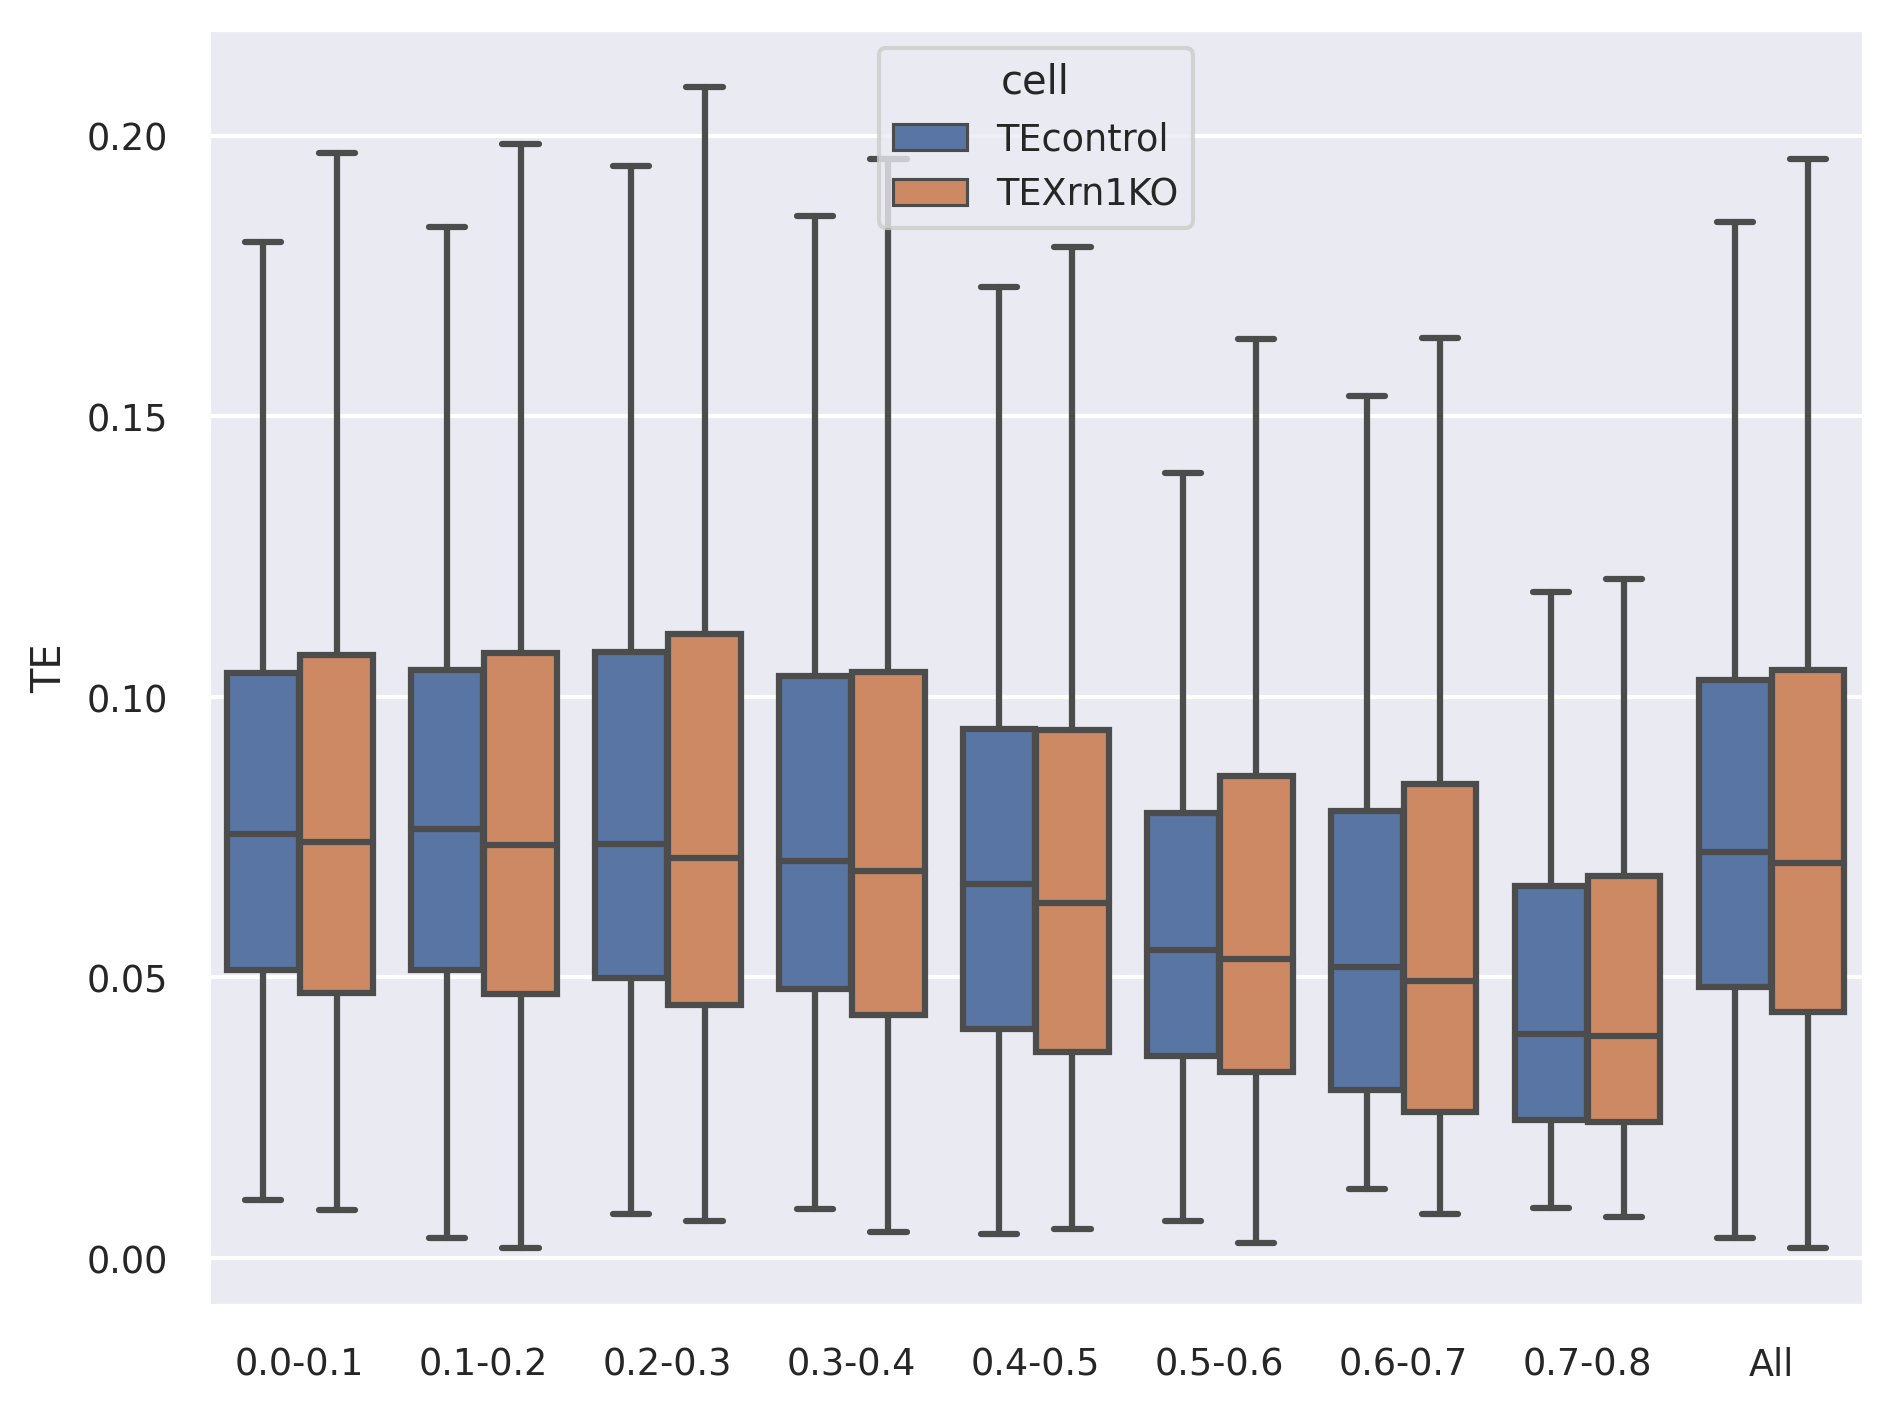

In [ ]:
target_labels=['TEcontrol', 'TEXrn1KO']
violin_data_dic,tick_names,bin_df = data_binning(merge,target_labels)
boxplot_hue(merge,violin_data_dic,tick_names)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.7-0.8 vs. All: Custom statistical test, P_val:1.000e-03
0.6-0.7 vs. All: Custom statistical test, P_val:1.000e-03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.7-0.8 vs. All: Custom statistical test, P_val:1.000e-03
0.6-0.7 vs. All: Custom statistical test, P_val:1.000e-03


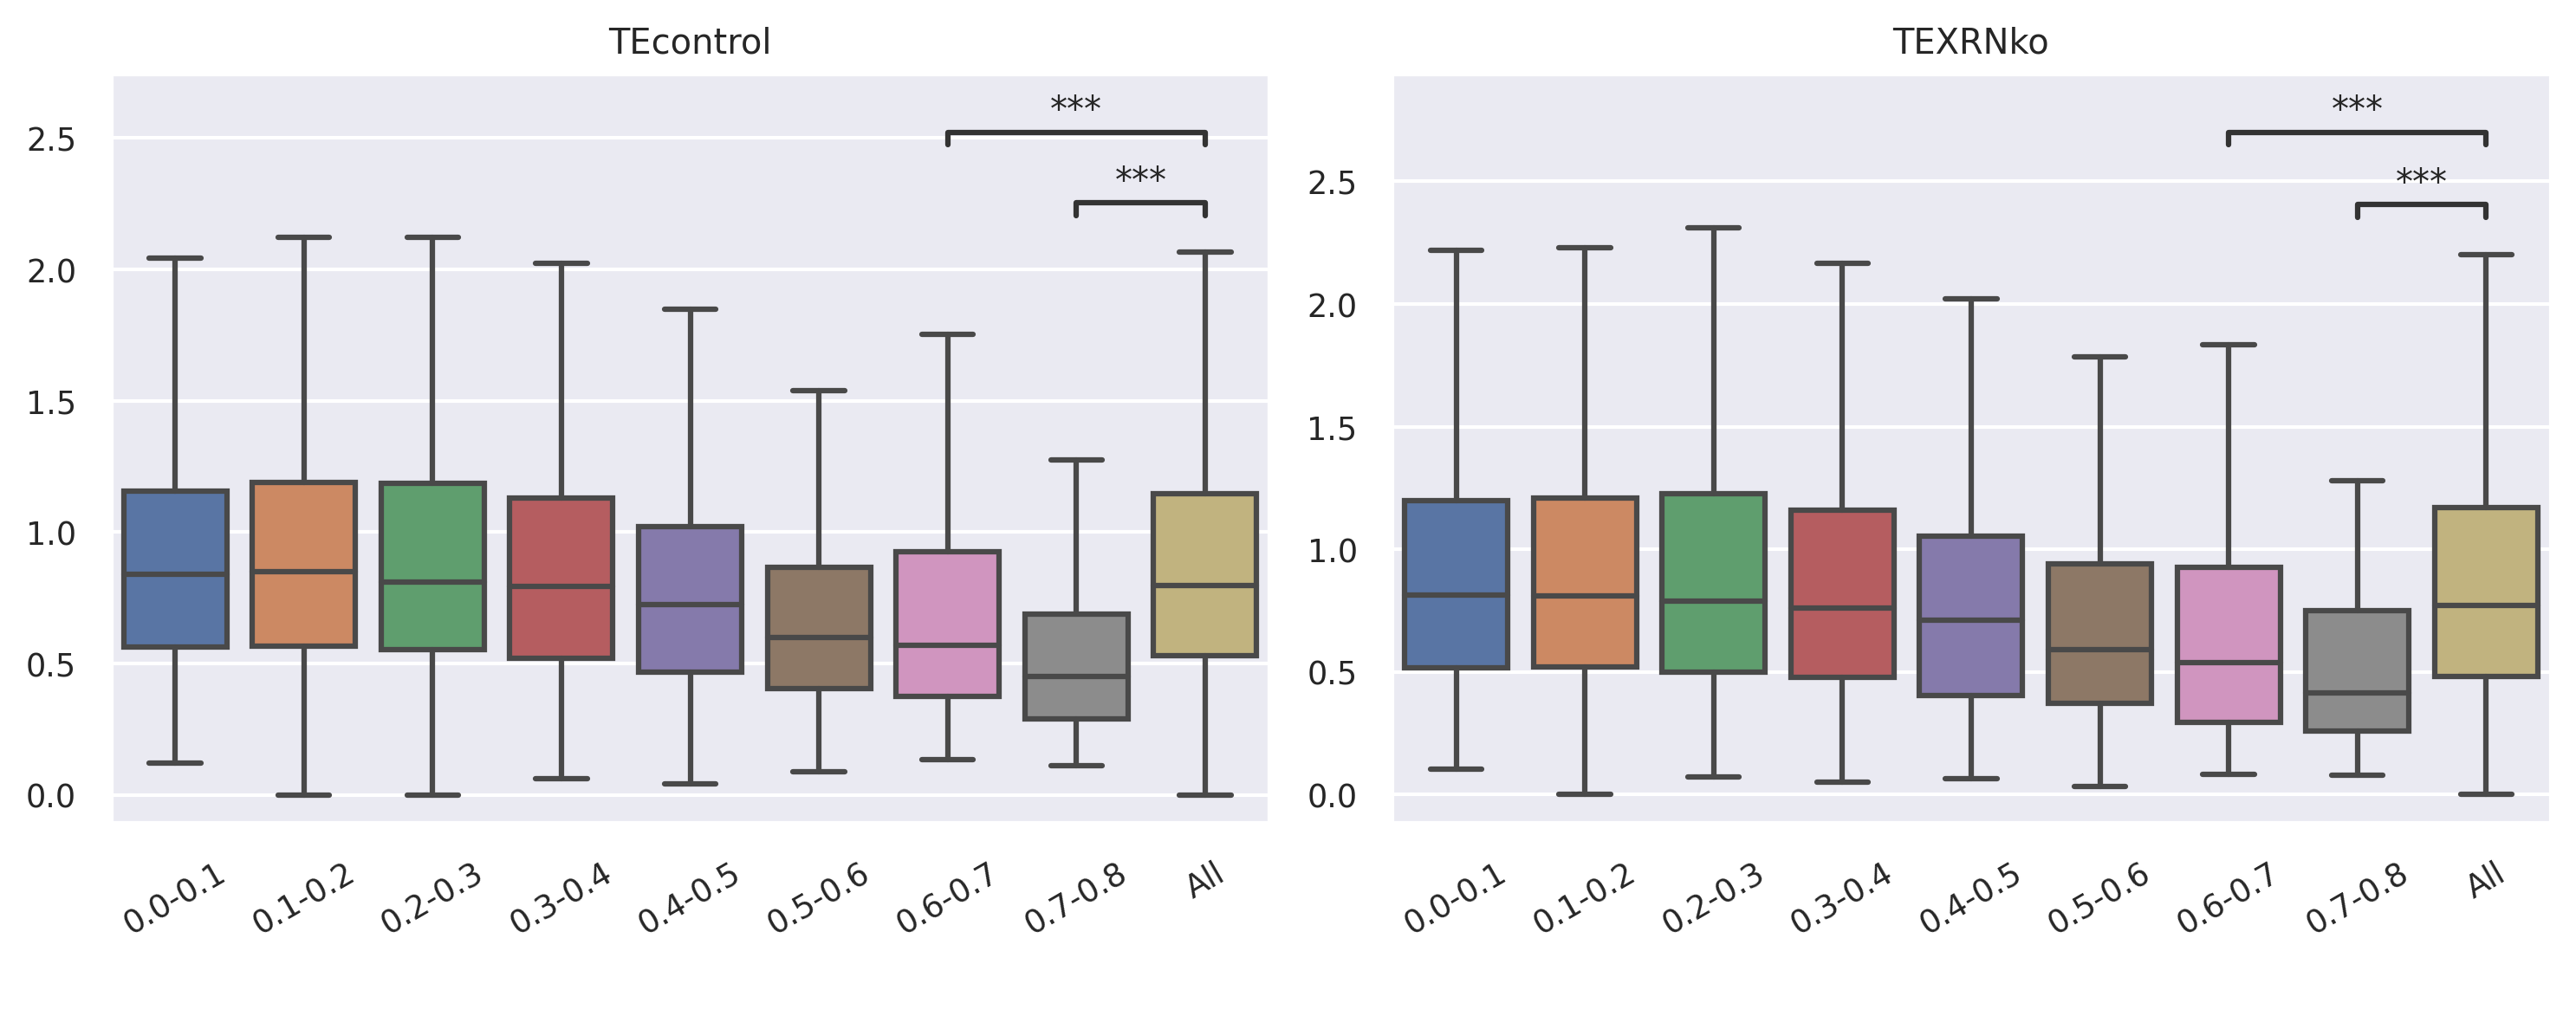

In [11]:
target_labels=['TEcontrol', 'TEXRNko']
violin_data_dic,tick_names,bin_df = data_binning(merge,target_labels)
boxplot_alltarget(df=merge,all_targets=target_labels,violin_data_dic=violin_data_dic,tick_names=tick_names)